In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from IPython.display import display
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from contextlib import contextmanager

from common_plotting import add_thp, read_thp, find_file, read_data
from common_analysis import filter_acal_points
from common_analysis_dcv import add_dut_neg_and_pos_group

plt.rcParams["figure.figsize"] = (10,6)
plt.rc('font', size=14)

In [2]:
thp_sorted = read_thp()

# Resistance
## Comparing 10k and 100k resistance range on 3458A

The hypothesis was that the 100k range on the 3458A might be more stable for measuring 10 kOhm than the 10k range, so I tested this by meauring the SR104 and Fluke 5450A (10k) in both ranges.

For the analysis I looked for equal length stretches that were close to each other in time. That might not make the most sense since we're looking at comparing standard deviations, rather than absolute values.

In [3]:
res_10k_100k_comparison = pd.read_csv(find_file("ks3458a-4w-res-log-10k-100k-test.csv"), parse_dates=['datetime'])

In [4]:
res_10k_100k_comparison['group'] = (res_10k_100k_comparison[['dut', 'dut_setting', 'last_acal_2_cal72']].apply(tuple, axis=1) != res_10k_100k_comparison[['dut', 'dut_setting', 'last_acal_2_cal72']].shift().apply(tuple, axis=1)).cumsum().rename('group')

In [5]:
res_10k_100k_comparison.groupby('group').count()

,datetime,dut,dut_setting,ag3458a_2_ohm,temp_2,last_acal_2,last_acal_2_cal72,ag3458a_2_range
group,,,,,,,,
1,204,204,204,204,24,204,204,204
2,54,54,54,54,5,54,54,54
3,57,57,57,57,8,57,57,57
4,96,96,96,96,11,96,96,96
5,44,44,44,44,6,44,44,44
6,339,339,339,339,38,339,339,339


In [6]:
res_10k_100k_comparison_equal_counts = pd.concat([res_10k_100k_comparison[res_10k_100k_comparison.group == 1].tail(44), res_10k_100k_comparison[res_10k_100k_comparison.group == 2].head(44), res_10k_100k_comparison[res_10k_100k_comparison.group == 3].tail(44), res_10k_100k_comparison[res_10k_100k_comparison.group == 4].head(44), res_10k_100k_comparison[res_10k_100k_comparison.group == 5].tail(44), res_10k_100k_comparison[res_10k_100k_comparison.group == 6].head(44)])

In [7]:
res_10k_100k_comparison_equal_counts.groupby('group').agg({'dut': 'last', 'dut_setting': 'last', 'ag3458a_2_range': 'last', 'ag3458a_2_ohm': ['mean', 'std', 'count']})

dut dut_setting ag3458a_2_range ag3458a_2_ohm                
              last        last            last          mean       std count
group                                                                       
1            SR104     10 kOhm           10000  10000.058187  0.001831    44
2      Fluke 5450A     10 kOhm           10000  10000.447271  0.001022    44
3      Fluke 5450A     10 kOhm           10000  10000.468134  0.001130    44
4            SR104     10 kOhm           10000  10000.069491  0.001294    44
5            SR104     10 kOhm          100000  10000.070929  0.002691    44
6      Fluke 5450A     10 kOhm          100000  10000.475453  0.003017    44

## Trying different ways of measuring the P4017 10 MOhm resistor

xdevs.com IRC user Alexey gave me the advise to connect guard to the screw on the side for the P4017, not the E binding post on top. That one is only for driven guard. Also he suggested to use shielded lead, possibly RG-58, to reduce noise.

I did measurements using a 2w shielded PTFE cable with guard connected to the E binding posts and with the guard connected to the screw on the side. I also tested with RG-58 cables with BNC-to-banana adapters on both sides, and connecting both shields to the screw on the side.

In [8]:
res_2w_data = pd.read_csv(find_file("ks3458a-2w-res-log.csv"), parse_dates=['datetime'])

/tmp/ipykernel_20496/3065554701.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  res_2w_data = pd.read_csv(find_file("ks3458a-2w-res-log.csv"), parse_dates=['datetime'])


In [9]:
p4017_raw_data = res_2w_data[(res_2w_data.datetime > pd.Timestamp(2022,9,25,0)) & (res_2w_data.datetime < pd.Timestamp(2022,11,2))].copy()
p4017_raw_data.loc[p4017_raw_data.dut == 'P4017', 'dut'] = 'P4017-1m-2w-PTFE-guard-to-E'
p4017_raw_data = p4017_raw_data[p4017_raw_data.dut != 'P4017-1m-RG58-to-spade-lug-lo-guard-to-lo-and-E-and-side']
p4017_data = p4017_raw_data[(p4017_raw_data.temp_2.isna().shift(1).fillna(False) & p4017_raw_data.temp_2.isna())]
p4017_data = p4017_data.groupby('dut').apply(lambda x: x.iloc[:5000]).reset_index(drop=True)

p4017_data['E'] = 'open'
p4017_data.loc[p4017_data.dut.str.contains('E-to-ground'), 'E'] = 'ground'
p4017_data.loc[p4017_data.dut.str.contains('E-and-side-to-ground'), 'E'] = 'ground'
p4017_data.loc[p4017_data.dut.str.contains('guard-to-E'), 'E'] = 'guard'
p4017_data.loc[p4017_data.dut.str.contains('guard-to-lo-and-E'), 'E'] = 'guard'

p4017_data['side'] = 'open'
p4017_data.loc[p4017_data.dut.str.contains('side-to-ground'), 'side'] = 'ground'
p4017_data.loc[p4017_data.dut.str.contains('side-and-E-to-ground'), 'side'] = 'ground'
p4017_data.loc[p4017_data.dut.str.contains('guard-to-side'), 'side'] = 'guard'
p4017_data.loc[p4017_data.dut.str.contains('guard-to-lo-and-side'), 'side'] = 'guard'
p4017_data.loc[p4017_data.dut.str.contains('guard-to-lo-and-E-and-side'), 'side'] = 'guard'
p4017_data.loc[p4017_data.dut.str.contains('guard-on-both-cables-to-lid-and-side'), 'side'] = 'guard'

p4017_data['E'] = 'open'
p4017_data.loc[p4017_data.dut.str.contains('E-to-ground'), 'E'] = 'ground'
p4017_data.loc[p4017_data.dut.str.contains('E-and-side-to-ground'), 'E'] = 'ground'
p4017_data.loc[p4017_data.dut.str.contains('guard-and-E-and-side-to-ground'), 'E'] = 'guard + ground'
p4017_data.loc[p4017_data.dut.str.contains('guard-to-E'), 'E'] = 'guard'
p4017_data.loc[p4017_data.dut.str.contains('guard-to-lo-and-E'), 'E'] = 'guard'

p4017_data['A'] = 'lo'
p4017_data.loc[p4017_data.dut.str.contains('guard-to-lo'), 'A'] = 'lo + guard'

p4017_data['B'] = 'hi'

p4017_data['cable'] = '1m 2w PTFE'
p4017_data.loc[p4017_data.dut.str.contains('1m-RG58'), 'cable'] = '2x 1m RG58'

p4017_data['connector'] = 'low-EMF spade lugs'
p4017_data.loc[p4017_data.dut.str.contains('RG58-to-male-banana'), 'connector'] = 'BNC-to-banana'

#p4017_data.groupby('dut').agg({'ag3458a_2_ohm': ['mean', 'std', 'sem', 'count']})
p4017_data.groupby(['side', 'E', 'A', 'B', 'cable', 'connector']).agg({'ag3458a_2_ohm': ['mean', 'std', 'sem', 'count']}).sort_values(by=('ag3458a_2_ohm', 'std'))
#, 'E': 'last', 'side': 'last', 'A': 'last', 'B': 'last'})

ag3458a_2_ohm  \
                                                                           mean   
side   E              A          B  cable      connector                          
guard  guard          lo + guard hi 1m 2w PTFE low-EMF spade lugs  1.000009e+07   
                                    2x 1m RG58 low-EMF spade lugs  1.000015e+07   
       open           lo + guard hi 1m 2w PTFE low-EMF spade lugs  1.000010e+07   
ground guard          lo + guard hi 1m 2w PTFE low-EMF spade lugs  1.000015e+07   
       ground         lo + guard hi 1m 2w PTFE low-EMF spade lugs  1.000007e+07   
guard  open           lo         hi 2x 1m RG58 BNC-to-banana       1.000022e+07   
                                    1m 2w PTFE low-EMF spade lugs  1.000017e+07   
ground open           lo + guard hi 1m 2w PTFE low-EMF spade lugs  1.000007e+07   
open   guard          lo         hi 1m 2w PTFE low-EMF spade lugs  1.000017e+07   
ground guard + ground lo         hi 1m 2w PTFE low-EMF spade lugs  1.000005e+07   
       guard          lo         hi 1m 2w PTFE low-EMF spade lugs  1.000003e+07   

                                                                               \
                                                                          std   
side   E              A          B  cable      connector                        
guard  guard          lo + guard hi 1m 2w PTFE low-EMF spade lugs    3.130751   
                                    2x 1m RG58 low-EMF spade lugs    3.464794   
       open           lo + guard hi 1m 2w PTFE low-EMF spade lugs    3.532471   
ground guard          lo + guard hi 1m 2w PTFE low-EMF spade lugs   17.092296   
       ground         lo + guard hi 1m 2w PTFE low-EMF spade lugs   24.020101   
guard  open           lo         hi 2x 1m RG58 BNC-to-banana        35.939575   
                                    1m 2w PTFE low-EMF spade lugs   48.905488   
ground open           lo + guard hi 1m 2w PTFE low-EMF spade lugs   53.087121   
open   guard          lo         hi 1m 2w PTFE low-EMF spade lugs   96.845226   
ground guard + ground lo         hi 1m 2w PTFE low-EMF spade lugs  100.839148   
       guard          lo         hi 1m 2w PTFE low-EMF spade lugs  132.697402   

                                                                             \
                                                                        sem   
side   E              A          B  cable      connector                      
guard  guard          lo + guard hi 1m 2w PTFE low-EMF spade lugs  0.044276   
                                    2x 1m RG58 low-EMF spade lugs  0.049000   
       open           lo + guard hi 1m 2w PTFE low-EMF spade lugs  0.049957   
ground guard          lo + guard hi 1m 2w PTFE low-EMF spade lugs  0.241722   
       ground         lo + guard hi 1m 2w PTFE low-EMF spade lugs  0.339696   
guard  open           lo         hi 2x 1m RG58 BNC-to-banana       0.508262   
                                    1m 2w PTFE low-EMF spade lugs  1.353275   
ground open           lo + guard hi 1m 2w PTFE low-EMF spade lugs  0.828476   
open   guard          lo         hi 1m 2w PTFE low-EMF spade lugs  3.980314   
ground guard + ground lo         hi 1m 2w PTFE low-EMF spade lugs  1.426081   
       guard          lo         hi 1m 2w PTFE low-EMF spade lugs  1.993254   

                                                                         
                                                                  count  
side   E              A          B  cable      connector                 
guard  guard          lo + guard hi 1m 2w PTFE low-EMF spade lugs  5000  
                                    2x 1m RG58 low-EMF spade lugs  5000  
       open           lo + guard hi 1m 2w PTFE low-EMF spade lugs  5000  
ground guard          lo + guard hi 1m 2w PTFE low-EMF spade lugs  5000  
       ground         lo + guard hi 1m 2w PTFE low-EMF spade lugs  5000  
guard  open           lo         hi 2x 1m RG58 BNC-to-banana       50

In [10]:
p4017_raw_data[~(p4017_raw_data.temp_2.isna().shift(1).fillna(False) & p4017_raw_data.temp_2.isna())]

,datetime,dut,dut_setting,ag3458a_2_ohm,temp_2,last_acal_2,last_acal_2_cal72,ag3458a_2_range
5273,2022-09-25 14:35:09.381673,P4017-1m-2w-PTFE-guard-to-E,10 MOhm,1.000018e+07,50.6,2022-09-25T14:10:54.658406,999.480856E-03,10000000.0
5274,2022-09-25 14:35:13.485722,P4017-1m-2w-PTFE-guard-to-E,10 MOhm,1.000010e+07,NaN,2022-09-25T14:10:54.658406,999.480856E-03,10000000.0
5490,2022-09-25 14:50:02.635417,P4017-1m-2w-PTFE-guard-to-E,10 MOhm,9.999530e+06,50.6,2022-09-25T14:10:54.658406,999.480856E-03,10000000.0
5491,2022-09-25 14:50:06.743275,P4017-1m-2w-PTFE-guard-to-E,10 MOhm,1.000021e+07,NaN,2022-09-25T14:10:54.658406,999.480856E-03,10000000.0
5710,2022-09-25 15:05:05.852003,P4017-1m-2w-PTFE-guard-to-E,10 MOhm,9.999571e+06,50.4,2022-09-25T14:10:54.658406,999.480856E-03,10000000.0
...,...,...,...,...,...,...,...,...
611279,2022-10-31 20:49:09.315134,P4017-1m-RG58-to-spade-lug-guard-to-lo-and-E-a...,10 MOhm,1.000012e+07,NaN,2022-10-07T12:32:49.117736,999.481069E-03,10000000.0
611498,2022-10-31 21:04:07.971116,P4017-1m-RG58-to-spade-lug-guard-to-lo-and-E-a...,10 MOhm,1.000005e+07,49.2,2022-10-07T12:32:49.117736,999.481069E-03,10000000.0
611499,2022-10-31 21:04:12.079040,P4017-1m-RG58-to-spade-lug-guard-to-lo-and-E-a...,10 MOhm,1.000012e+07,NaN,2022-10-07T12:32:49.117736,999.481069E-03,10000000.0
611718,2022-10-31 21:19:10.755593,P4017-1m-RG58-to-spade-lug-guard-to-lo-and-E-a...,10 MOhm,1.000005e+07,49.1,2022-10-07T12:32:49.117736,999.481069E-03,10000000.0


In [11]:
# orig_max_rows = pd.get_option('display.max_rows')
# pd.set_option('display.max_rows', None)
#display(p4017_data.groupby('dut').apply(lambda x: x.ag3458a_2_ohm.rolling(100).std()))

# pd.set_option('display.max_rows', orig_max_rows)
p4017_moving_std = p4017_raw_data.groupby('dut').apply(lambda x: x.iloc[:5000]).reset_index(drop=True).groupby('dut').apply(lambda x: x.ag3458a_2_ohm.rolling(10).std()).dropna().to_frame().reset_index().drop(['level_1'], axis=1)

In [12]:
p4017_moving_std

,dut,ag3458a_2_ohm
0,P4017-1m-2w-PTFE-guard-and-E-and-side-to-ground,102.709841
1,P4017-1m-2w-PTFE-guard-and-E-and-side-to-ground,117.782303
2,P4017-1m-2w-PTFE-guard-and-E-and-side-to-ground,113.937794
3,P4017-1m-2w-PTFE-guard-and-E-and-side-to-ground,110.943691
4,P4017-1m-2w-PTFE-guard-and-E-and-side-to-ground,113.049568
...,...,...
45428,P4017-1m-RG58-to-spade-lug-guard-to-lo-and-E-a...,1.638997
45429,P4017-1m-RG58-to-spade-lug-guard-to-lo-and-E-a...,2.091187
45430,P4017-1m-RG58-to-spade-lug-guard-to-lo-and-E-a...,1.993735
45431,P4017-1m-RG58-to-spade-lug-guard-to-lo-and-E-a...,1.998926


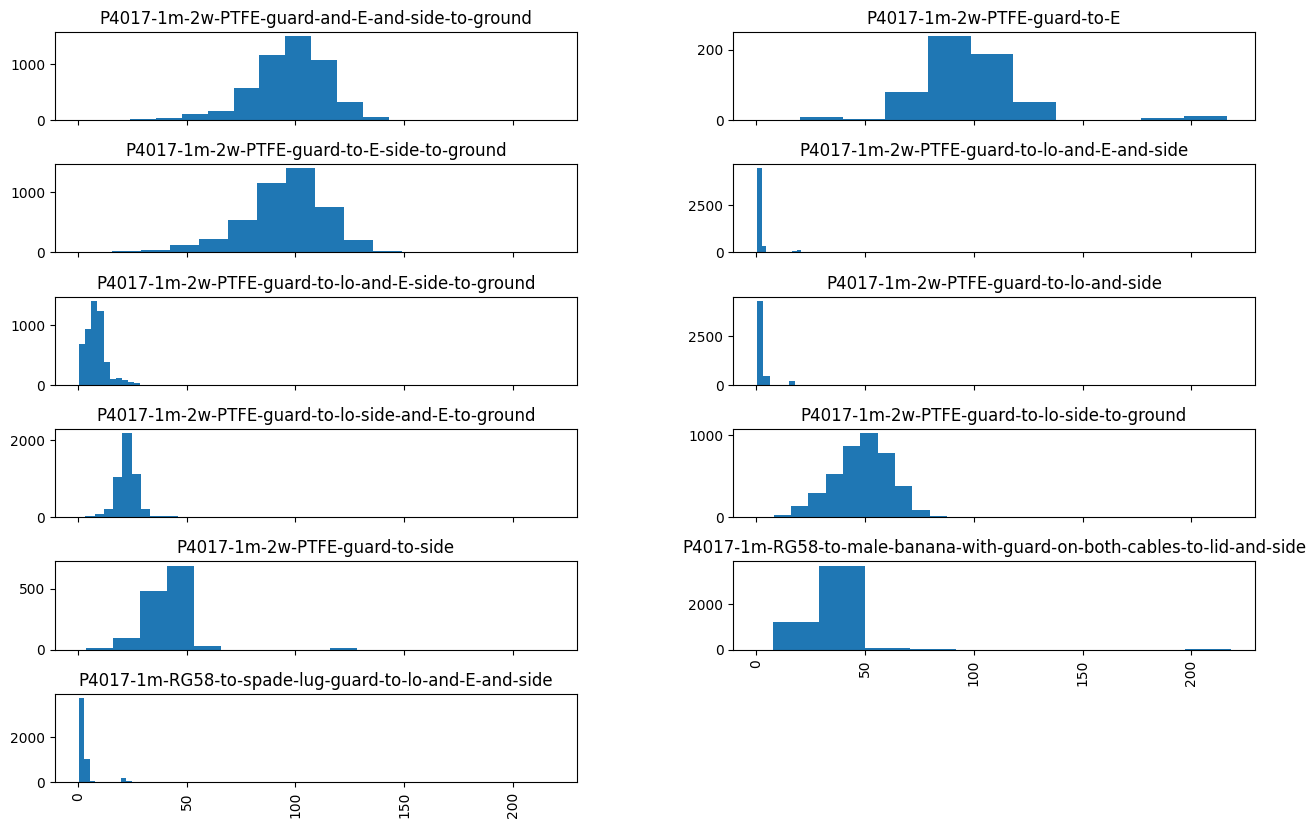

In [13]:
plt.rc('font', size=10)
p4017_moving_std.hist(by='dut', layout=(6,2), sharex=True, figsize=(15, 10))
plt.xlabel('Standard deviation of 10 sample windows (Ohm)')
plt.rc('font', size=14)

Text(0, 0.5, 'temperature [°C]')

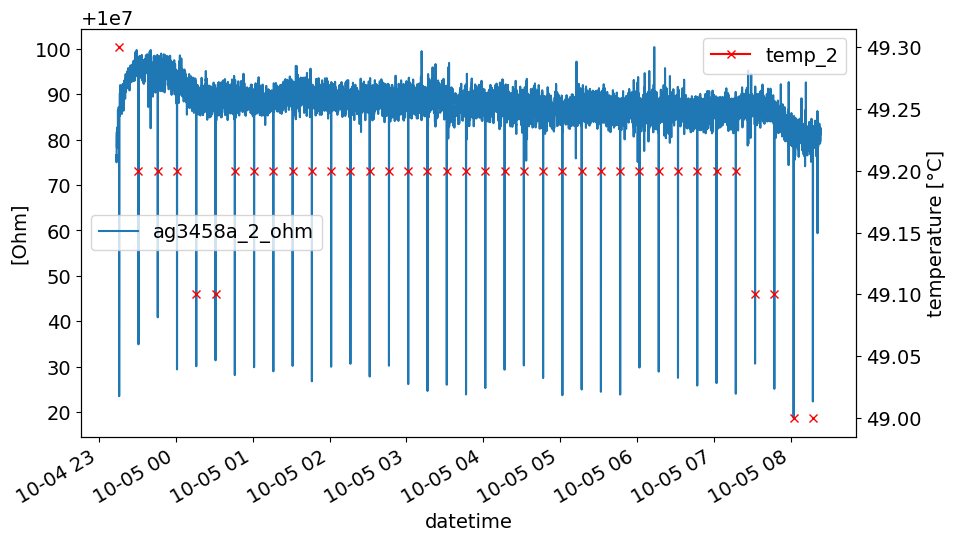

In [14]:
p4017_plot_data = p4017_raw_data[p4017_raw_data.dut == 'P4017-1m-2w-PTFE-guard-to-lo-and-E-and-side']
ax = p4017_plot_data.plot('datetime', 'ag3458a_2_ohm')
plt.ylabel('[Ohm]')
ax2 = ax.twinx()
p4017_plot_data.plot('datetime', 'temp_2', ax=ax2, marker='x', color='red')
plt.ylabel('temperature [°C]')

Text(0, 0.5, 'temperature [°C]')

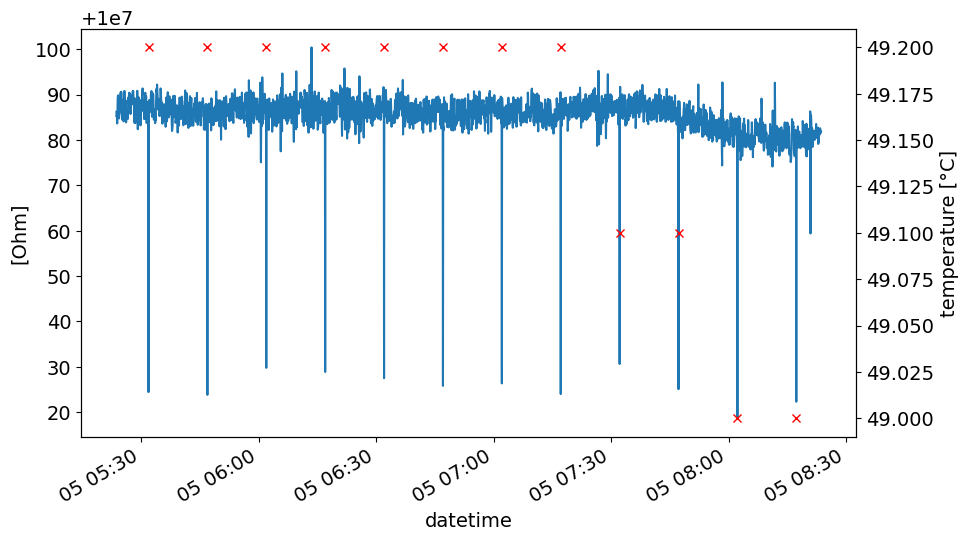

In [15]:
p4017_plot_data = p4017_raw_data[p4017_raw_data.dut == 'P4017-1m-2w-PTFE-guard-to-lo-and-E-and-side'].set_index('datetime').last('3h')
ax = p4017_plot_data['ag3458a_2_ohm'].plot()
plt.ylabel('[Ohm]')
ax2 = ax.twinx()
p4017_plot_data['temp_2'].plot(ax=ax2, marker='x', color='red')
plt.ylabel('temperature [°C]')

Text(0, 0.5, 'temperature [°C]')

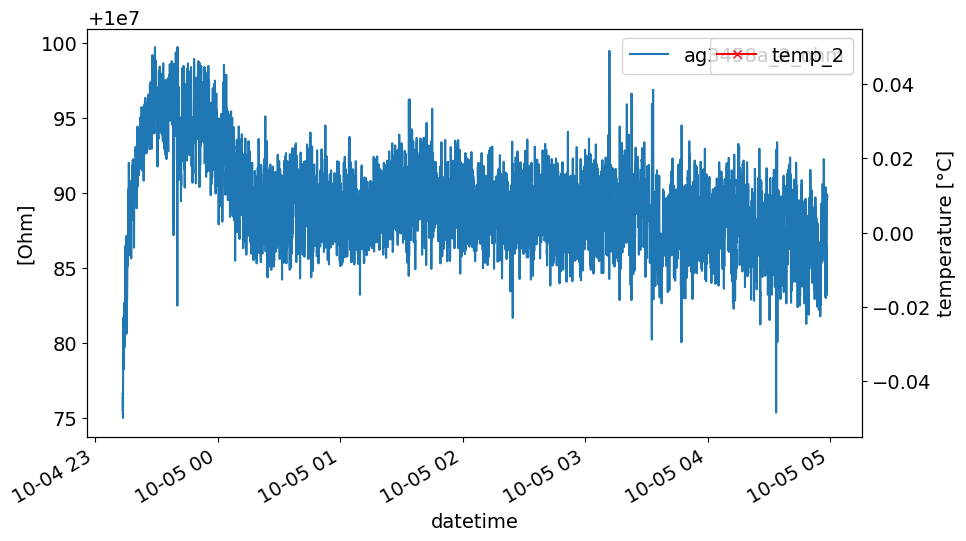

In [16]:
p4017_plot_data = p4017_data[p4017_data.dut == 'P4017-1m-2w-PTFE-guard-to-lo-and-E-and-side']
ax = p4017_plot_data.plot('datetime', 'ag3458a_2_ohm')
plt.ylabel('[Ohm]')
ax2 = ax.twinx()
p4017_plot_data.plot('datetime', 'temp_2', ax=ax2, marker='x', color='red')
plt.ylabel('temperature [°C]')

Text(0, 0.5, 'temperature [°C]')

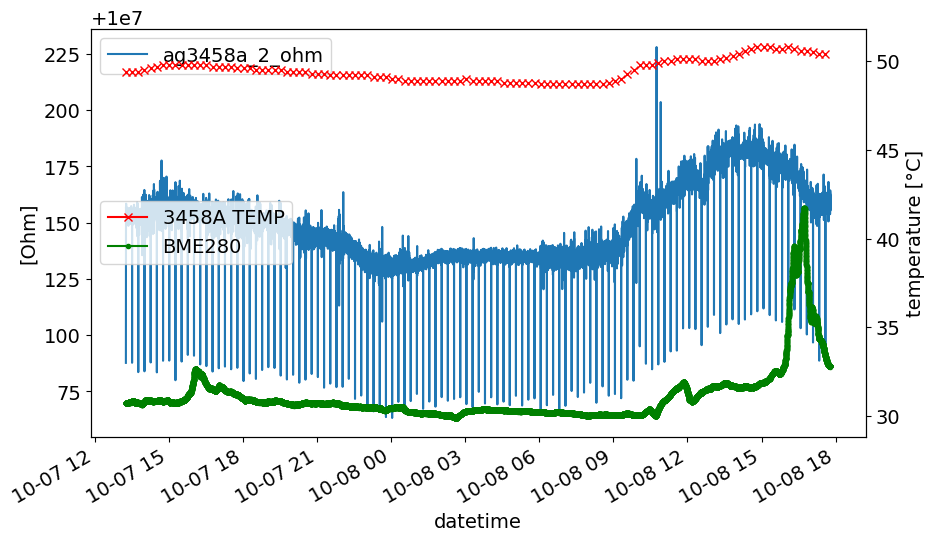

In [17]:
p4017_plot_data = p4017_raw_data[p4017_raw_data.dut == 'P4017-1m-RG58-to-spade-lug-guard-to-lo-and-E-and-side'].iloc[:25000]


    
p4017_plot_data = add_thp(thp_sorted, p4017_plot_data).reset_index()
ax = p4017_plot_data.plot('datetime', 'ag3458a_2_ohm')
plt.ylabel('[Ohm]')
ax2 = ax.twinx()
p4017_plot_data.plot('datetime', 'temp_2', ax=ax2, marker='x', color='red', label='3458A TEMP')
p4017_plot_data.plot('datetime', 'temperature', ax=ax2, marker='.', color='green', label='BME280')
plt.ylabel('temperature [°C]')

### Data from Alexey

#### R4023 50PLC short leads

,ohm
mean,1.000016e+07
std,1.384962e+00
sem,2.016744e-02
count,4.716000e+03


Text(0.5, 0, 'Standard deviation of 100 sample windows (Ohm)')

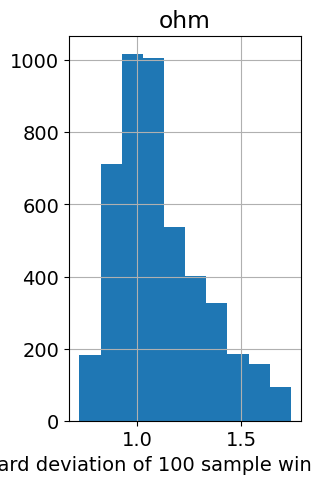

In [18]:
r4023_data = pd.read_table('R4023_50plc_shortleads__', header=None, names=['timestamp', 'ohm'], sep='\s+')
display(r4023_data.agg({'ohm': ['mean', 'std', 'sem', 'count']}))
r4023_moving_std = r4023_data.ohm.rolling(100).std().dropna().to_frame()
r4023_moving_std.hist(figsize=(3, 5))
plt.xlabel('Standard deviation of 100 sample windows (Ohm)')

#### R4023 100PLC short leads
2w short length wire (about 10cm), 100plc, delay 1s
guard terminal of DMM connected to outer guard of R4023, gnd terminal terminal connected to "2" terminal of R4023 and inner guard

during this measurement, the temperature did not change by more than 0.5 degrees (total)

,ohm
mean,1.000016e+07
std,1.266523e+00
sem,2.803442e-02
count,2.041000e+03


Text(0.5, 0, 'Standard deviation of 100 sample windows (Ohm)')

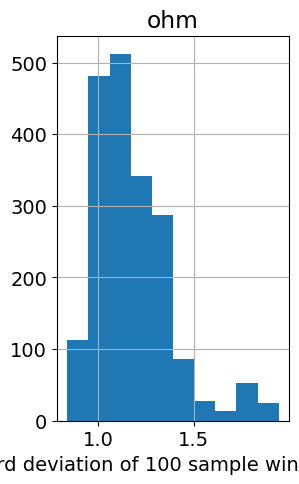

In [19]:
r4023_data = pd.read_table('R4023_100plc_delay_1s.txt', header=None, names=['timestamp', 'ohm'], sep='\s+')
display(r4023_data.agg({'ohm': ['mean', 'std', 'sem', 'count']}))
r4023_moving_std = r4023_data.ohm.rolling(100).std().dropna().to_frame()
r4023_moving_std.hist(figsize=(3, 5))
plt.xlabel('Standard deviation of 100 sample windows (Ohm)')

In [20]:
5.100/1.3849

3.6825763593039205

## Test of 3458A OCOMP + DELAY interaction
It was postulated that the necessary delay to compensate for DA during resistance measurements with offset compensation depends on cabling and possibly even on the capatitance of the resistor. So I compared the SR104, other standard resistors and the 5450A with different values of delay. On the SR104 and 5450A I had the guard lead connected to the guard terminal and guard switch to LO, and for the other resistors I had the guard lead loose and the guard switch on the 3458A set to LO.

On the SR104 measurements with the 1m cable I made the first set of measurements until 2022-9-24 9.19 (UTC).

In [21]:
res_delay_test_data = pd.read_csv(find_file("ks3458a-4w-res-delay-test2.csv"), parse_dates=['datetime']).set_index('datetime', drop=True)
res_delay_test_data_group1 = res_delay_test_data[res_delay_test_data.index < pd.Timestamp(2022,9,26,0)].copy()
res_delay_test_data_group2 = res_delay_test_data[(res_delay_test_data.index >= pd.Timestamp(2022,9,26,19,15)) & (res_delay_test_data.index < pd.Timestamp(2022,10,2,0))].copy()

In [22]:
def show_counts(delay_test_data):
    return delay_test_data.groupby(['dut', 'dut_setting', 'cable']).agg({'ag3458a_2_ohm': 'count'})

def sub_first_value_from_every_value(column, df):
    df[f'rel_{column}_ppm'] = (df[column] / df.iloc[0][column] - 1) * 1e6
    return df

def exp_decay(t,V,tau):
    return V * (1-np.exp(-t/tau))

def inv_exp_decay(diff, V0, tau):
    return -tau * np.log(diff/np.abs(V0))
    

def reciprocal(t, a, h, k):
    return -a / (t + h) + k

def inv_reciprocal(diff, a, h, k):
    return -a / -diff - h

def plot_and_fit_delay_results(delay_test_results, fit_function=exp_decay, fit_param_names=['V0', 'tau']):
    delay_test_results_grouped = delay_test_results.groupby(['group', 'ag3458a_2_delay'], axis=0).agg({'rel_ag3458a_2_ohm_ppm': ['mean', 'std', 'sem', 'count'], 'dut': 'last', 'dut_setting': 'last', 'cable': 'last', 'ag3458a_2_range': 'last'}).reset_index()
    cmap = plt.get_cmap('jet')
    fit_results_list = []
    for cable in delay_test_results_grouped['cable']['last'].unique():
        cable_data = delay_test_results_grouped[delay_test_results_grouped['cable']['last'] == cable]
        for resistance_range, range_data in (('1 kOhm', cable_data[cable_data['dut_setting']['last'] == '1 kOhm']), ('>= 10 kOhm', cable_data[cable_data['dut_setting']['last'] != '1 kOhm'])):
            number_of_groups = len(range_data.group.unique())
            with do_delay_plot({'cable': cable, 'resistance_range': resistance_range}):
                for i, group in enumerate(range_data.group.unique()):
                    plot_data = range_data[range_data.group == group]
                    color = cmap(i / number_of_groups)
                    plot_fit_results = plot_and_fit_group(plot_data, color, fit_function, fit_param_names)
                    plot_fit_results['group'] = group
                    fit_results_list.append(plot_fit_results)
    fit_results = pd.DataFrame(columns=['group'] + fit_param_names, data=fit_results_list).set_index('group', drop=True)
    return delay_test_results_grouped, fit_results

def plot_and_fit_group(plot_data, color, fit_function, fit_param_names, label_format='{dut}-{dut_setting}'):
    plt.errorbar(plot_data['ag3458a_2_delay'], plot_data['rel_ag3458a_2_ohm_ppm']['mean'], yerr=plot_data['rel_ag3458a_2_ohm_ppm']['sem'], label=label_format.format(dut=plot_data['dut']['last'].iloc[0], dut_setting=plot_data['dut_setting']['last'].iloc[0], range=plot_data['ag3458a_2_range']['last'].iloc[0]), fmt='o', c=color)
    fit_params, covariances = curve_fit(fit_function, plot_data['ag3458a_2_delay'], plot_data['rel_ag3458a_2_ohm_ppm']['mean'], sigma=plot_data['rel_ag3458a_2_ohm_ppm']['sem'].replace(0, 1e-3))
    x_for_fit = np.linspace(min(plot_data['ag3458a_2_delay']), max(plot_data['ag3458a_2_delay']), 100)
    y_fit = fit_function(x_for_fit, *fit_params)
    fit_label = ', '.join([f'{fit_param_name}={fit_params[fit_param_number]:.2}' for fit_param_number, fit_param_name in enumerate(fit_param_names)])
    plt.plot(x_for_fit, y_fit, label=fit_label, c=color)
    return {fit_param_name: fit_params[fit_param_number] for fit_param_number, fit_param_name in enumerate(fit_param_names)}


@contextmanager
def do_delay_plot(title_params = {}):
    plt.rc('font', size=12)
    try:
        yield
        plt.title('Delay for OCOMP resistance measurement with cable {cable} for resistances {resistance_range}'.format(**title_params))
        plt.xlabel('Delay (s)')
        plt.ylabel('Change relative to no delay (ppm)')
        plt.legend()
        plt.show()
    finally:
        plt.rc('font', size=14)


def display_fit_results(res_delay_test_results, fit_results, diff=0.05, inv_function=inv_exp_decay, fit_param_names=['V0', 'tau']):
    pd.set_option('display.precision', 2)
    groups = res_delay_test_results.droplevel(1, axis=1).groupby('group').agg({'cable': 'last', 'dut': 'last', 'dut_setting': 'last', 'ag3458a_2_range': 'last'})
    fit_results_with_group = groups.join(fit_results)
    fit_results_with_group[f'time (within {diff} ppm)'] = inv_function(diff, *[fit_results_with_group[fit_param_name] for fit_param_name in fit_param_names])
    display(fit_results_with_group.sort_values(['cable', 'dut_setting', 'dut']).set_index(['cable', 'dut_setting', 'dut', 'ag3458a_2_range'], drop=True))
    pd.reset_option('display.precision')

### Experiment 1

In [23]:
show_counts(res_delay_test_data_group1)

ag3458a_2_ohm
dut                      dut_setting cable                    
Fluke 5450A              1 kOhm      4w PTFE 1m            250
                                     4w PTFE 2m            410
                         10 kOhm     4w PTFE 1m            148
                                     4w PTFE 2m            122
                         100 kOhm    4w PTFE 1m            178
                                     4w PTFE 2m             92
Guildline 9330 s/n 51722 100 kOhm    4w PTFE 1m            283
                                     4w PTFE 2m            100
HP 11103A                1 kOhm      4w PTFE 1m            218
                                     4w PTFE 2m            296
SR104                    10 kOhm     4w PTFE 1m            434
                                     4w PTFE 2m            528

In [24]:
res_delay_test_data_group1['group'] = (res_delay_test_data_group1[['dut', 'dut_setting', 'cable']].apply(tuple, axis=1) != res_delay_test_data_group1[['dut', 'dut_setting', 'cable']].shift().apply(tuple, axis=1)).cumsum()
res_delay_test_data_group1['replicate'] = (res_delay_test_data_group1.ag3458a_2_delay == 0).cumsum()

In [25]:
# Remove first set from every group, because it did not start at 0
res_delay_test_data_filtered_group1 = res_delay_test_data_group1.groupby('group').apply(lambda x: x.iloc[x.ag3458a_2_delay.to_numpy().reshape(-1).tolist().index(0):])
# Subtract first value (at delay 0) from every value 

res_delay_test_data_with_rel_group1 = res_delay_test_data_filtered_group1.groupby('replicate').apply(partial(sub_first_value_from_every_value, 'ag3458a_2_ohm')).droplevel(0)
res_delay_test_data_with_rel_group1.index.rename(('index_group', 'datetime'), inplace=True)

#### Fit with exponential decay

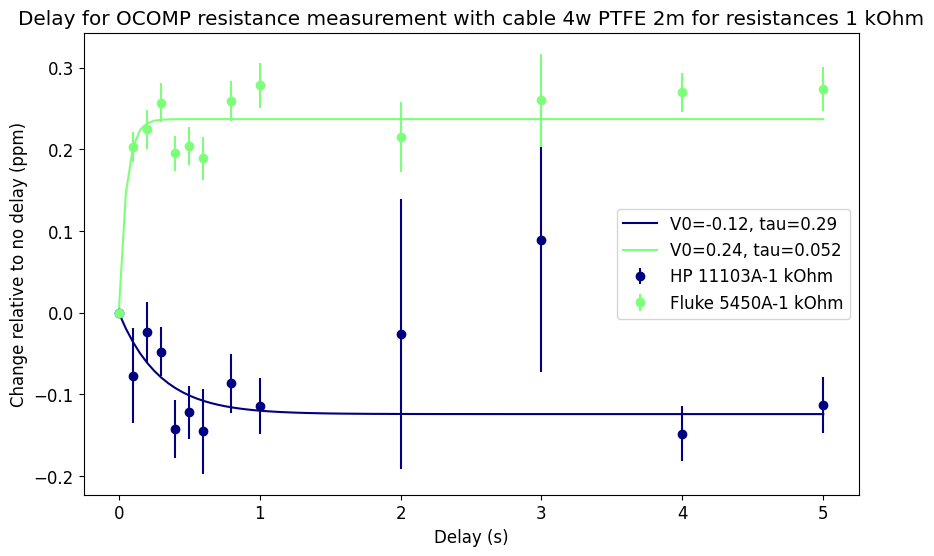

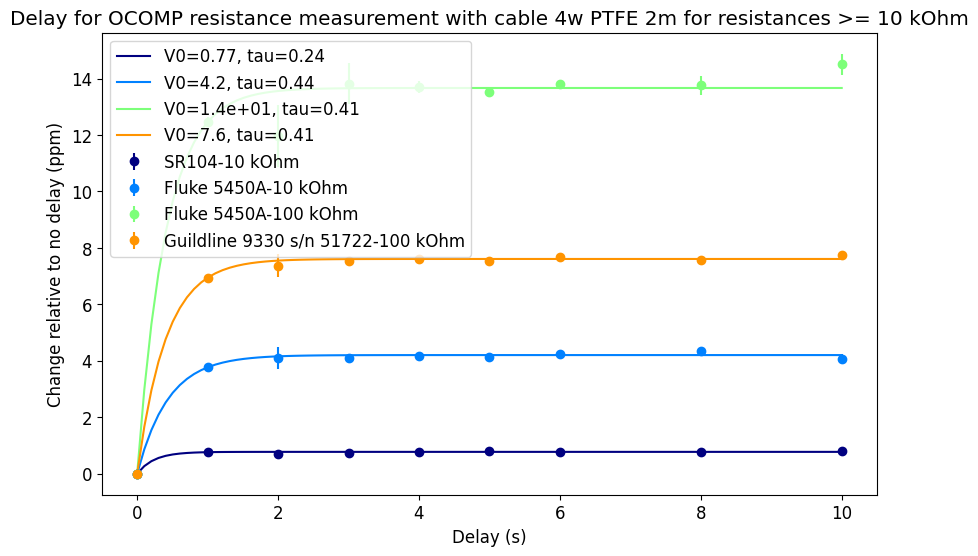

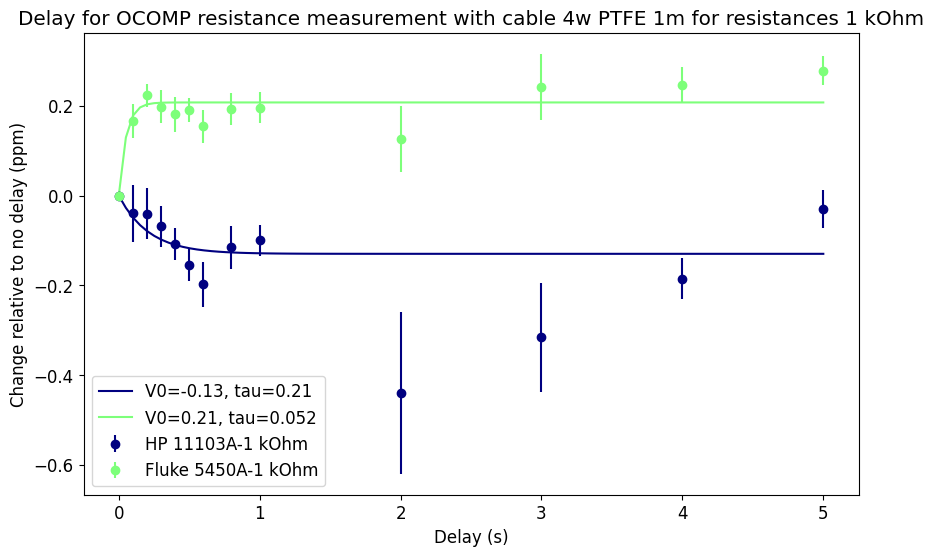

/home/alson/shared/projects/personal/electronics/t&m/automation/data-analysis/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/alson/shared/projects/personal/electronics/t&m/automation/data-analysis/.venv/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


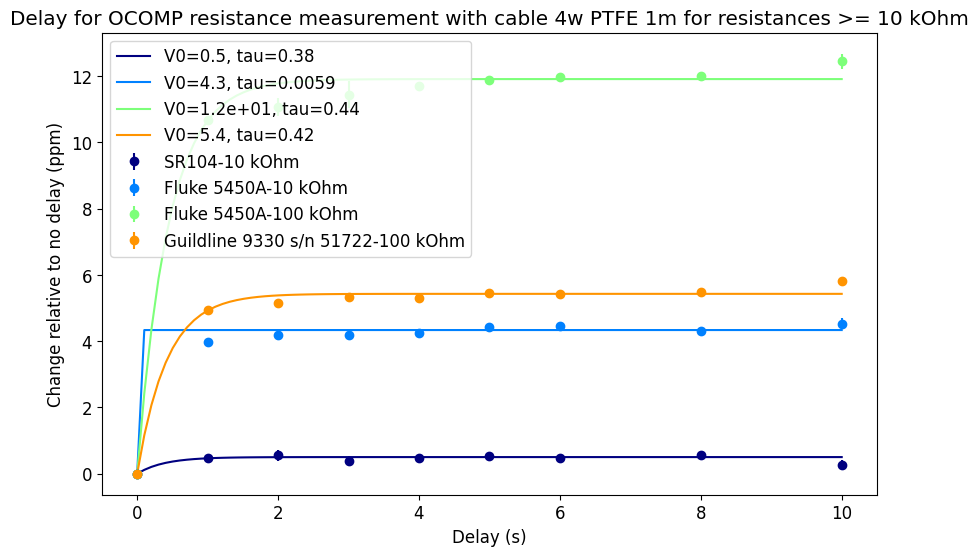

V0  \
cable      dut_setting dut                      ag3458a_2_range          
4w PTFE 1m 1 kOhm      Fluke 5450A              1000.0            0.21   
                       HP 11103A                1000.0           -0.13   
           10 kOhm     Fluke 5450A              10000.0           4.34   
                       SR104                    10000.0           0.50   
           100 kOhm    Fluke 5450A              100000.0         11.91   
                       Guildline 9330 s/n 51722 100000.0          5.43   
4w PTFE 2m 1 kOhm      Fluke 5450A              1000.0            0.24   
                       HP 11103A                1000.0           -0.12   
           10 kOhm     Fluke 5450A              10000.0           4.20   
                       SR104                    10000.0           0.77   
           100 kOhm    Fluke 5450A              100000.0         13.66   
                       Guildline 9330 s/n 51722 100000.0          7.61   

                                                                      tau  \
cable      dut_setting dut                      ag3458a_2_range             
4w PTFE 1m 1 kOhm      Fluke 5450A              1000.0           5.16e-02   
                       HP 11103A                1000.0           2.14e-01   
           10 kOhm     Fluke 5450A              10000.0          5.87e-03   
                       SR104                    10000.0          3.82e-01   
           100 kOhm    Fluke 5450A              100000.0         4.45e-01   
                       Guildline 9330 s/n 51722 100000.0         4.21e-01   
4w PTFE 2m 1 kOhm      Fluke 5450A              1000.0           5.25e-02   
                       HP 11103A                1000.0           2.95e-01   
           10 kOhm     Fluke 5450A              10000.0          4.40e-01   
                       SR104                    10000.0          2.37e-01   
           100 kOhm    Fluke 5450A              100000.0         4.12e-01   
                       Guildline 9330 s/n 51722 100000.0         4.10e-01   

                                                                 time (within 0.05 ppm)  
cable      dut_setting dut                      ag3458a_2_range                          
4w PTFE 1m 1 kOhm      Fluke 5450A              1000.0                             0.07  
                       HP 11103A                1000.0                             0.20  
           10 kOhm     Fluke 5450A              10000.0                            0.03  
                       SR104                    10000.0                            0.88  
           100 kOhm    Fluke 5450A              100000.0                           2.43  
                       Guildline 9330 s/n 51722 100000.0                           1.97  
4w PTFE 2m 1 kOhm      Fluke 5450A              1000.0                             0.08  
                       HP 11103A                1000.0                             0.27  
           10 kOhm     Fluke 5450A              10000.0                            1.95  
                       SR104                    10000.0                            0.65  
           100 kOhm    Fluke 5450A              100000.0                           2.31  
                       Guildline 9330 s/n 51722 100000.0                           2.06

In [26]:
delay_test_results_group1, fit_results_group1 = plot_and_fit_delay_results(res_delay_test_data_with_rel_group1)
delay_test_results_group1[['dut', 'dut_setting', 'cable', 'ag3458a_2_delay', 'rel_ag3458a_2_ohm_ppm']].sort_values([('cable', 'last'), ('dut_setting', 'last'), ('dut', 'last')]).to_csv('measurement-tests-delay-test-results.csv')
display_fit_results(delay_test_results_group1, fit_results_group1)

#### Fit with reciprocal function

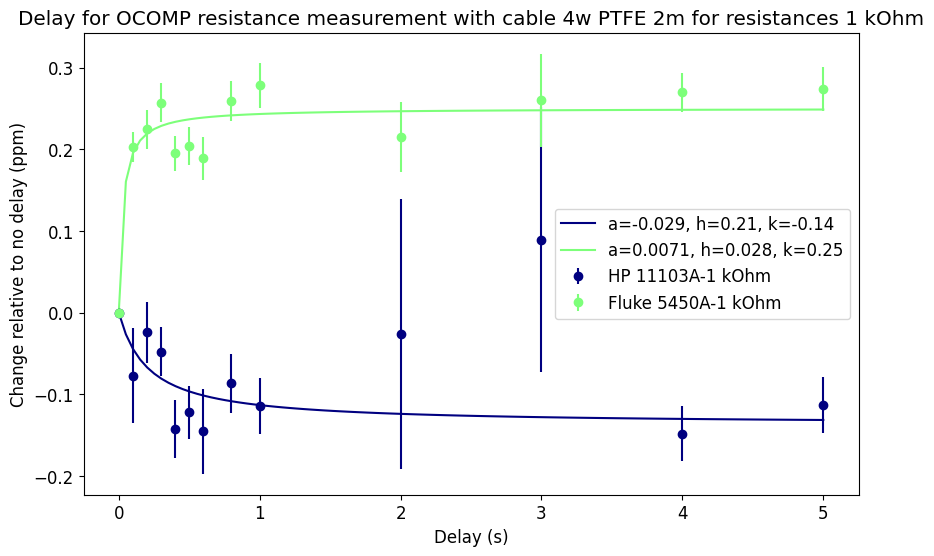

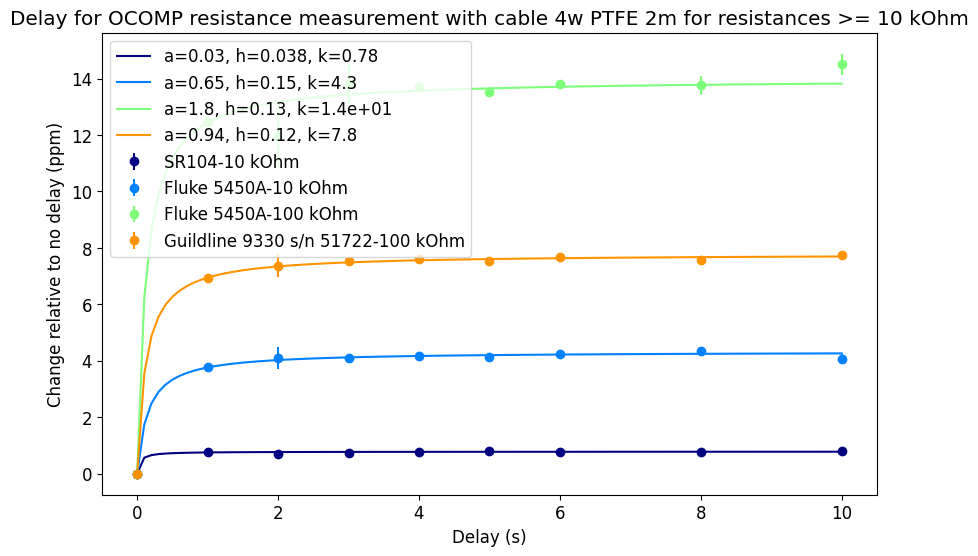

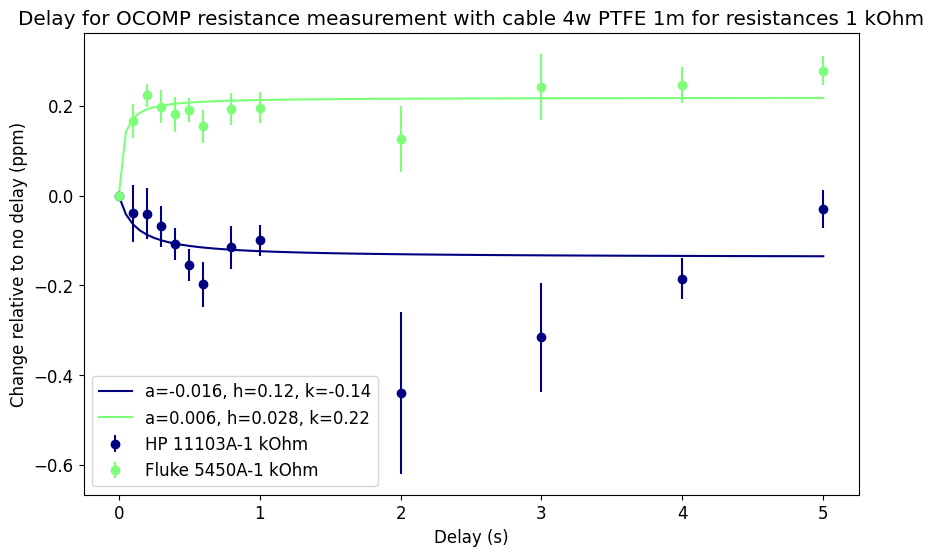

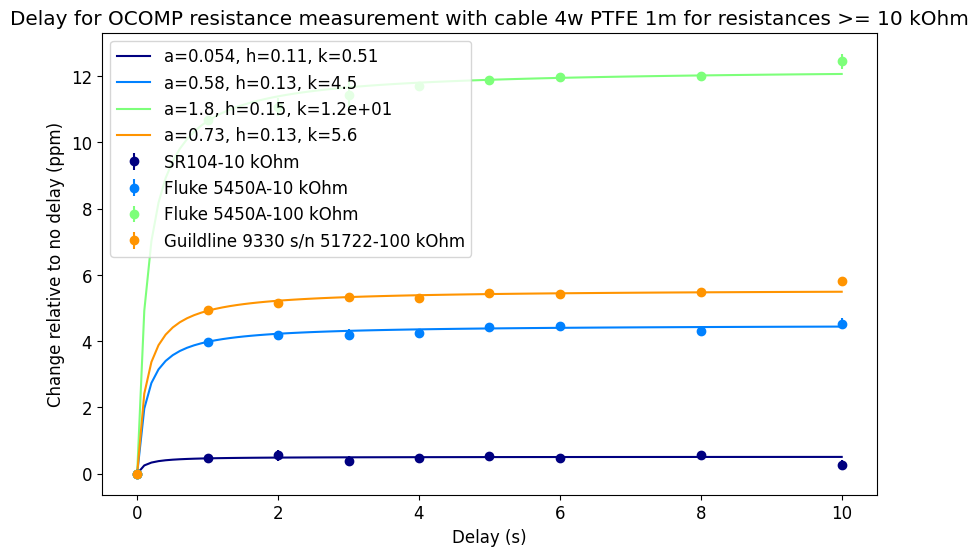

a  \
cable      dut_setting dut                      ag3458a_2_range             
4w PTFE 1m 1 kOhm      Fluke 5450A              1000.0           6.03e-03   
                       HP 11103A                1000.0          -1.62e-02   
           10 kOhm     Fluke 5450A              10000.0          5.84e-01   
                       SR104                    10000.0          5.43e-02   
           100 kOhm    Fluke 5450A              100000.0         1.84e+00   
                       Guildline 9330 s/n 51722 100000.0         7.32e-01   
4w PTFE 2m 1 kOhm      Fluke 5450A              1000.0           7.07e-03   
                       HP 11103A                1000.0          -2.87e-02   
           10 kOhm     Fluke 5450A              10000.0          6.47e-01   
                       SR104                    10000.0          2.97e-02   
           100 kOhm    Fluke 5450A              100000.0         1.76e+00   
                       Guildline 9330 s/n 51722 100000.0         9.44e-01   

                                                                    h      k  \
cable      dut_setting dut                      ag3458a_2_range                
4w PTFE 1m 1 kOhm      Fluke 5450A              1000.0           0.03   0.22   
                       HP 11103A                1000.0           0.12  -0.14   
           10 kOhm     Fluke 5450A              10000.0          0.13   4.50   
                       SR104                    10000.0          0.11   0.51   
           100 kOhm    Fluke 5450A              100000.0         0.15  12.25   
                       Guildline 9330 s/n 51722 100000.0         0.13   5.56   
4w PTFE 2m 1 kOhm      Fluke 5450A              1000.0           0.03   0.25   
                       HP 11103A                1000.0           0.21  -0.14   
           10 kOhm     Fluke 5450A              10000.0          0.15   4.33   
                       SR104                    10000.0          0.04   0.78   
           100 kOhm    Fluke 5450A              100000.0         0.13  13.99   
                       Guildline 9330 s/n 51722 100000.0         0.12   7.79   

                                                                 time (within 0.05 ppm)  
cable      dut_setting dut                      ag3458a_2_range                          
4w PTFE 1m 1 kOhm      Fluke 5450A              1000.0                             0.09  
                       HP 11103A                1000.0                            -0.44  
           10 kOhm     Fluke 5450A              10000.0                           11.55  
                       SR104                    10000.0                            0.98  
           100 kOhm    Fluke 5450A              100000.0                          36.71  
                       Guildline 9330 s/n 51722 100000.0                          14.51  
4w PTFE 2m 1 kOhm      Fluke 5450A              1000.0                             0.11  
                       HP 11103A                1000.0                            -0.78  
           10 kOhm     Fluke 5450A              10000.0                           12.78  
                       SR104                    10000.0                            0.56  
           100 kOhm    Fluke 5450A              100000.0                          35.05  
                       Guildline 9330 s/n 51722 100000.0                          18.76

In [27]:
delay_test_results_group1, fit_results_group1 = plot_and_fit_delay_results(res_delay_test_data_with_rel_group1, fit_function=reciprocal, fit_param_names=['a', 'h', 'k'])
display_fit_results(delay_test_results_group1, fit_results_group1, inv_function=inv_reciprocal, fit_param_names=['a', 'h', 'k'])

### Experiment 2

In [28]:
res_delay_test_data_group2['group'] = (res_delay_test_data_group2[['dut', 'dut_setting', 'cable', 'ag3458a_2_range']].apply(tuple, axis=1) != res_delay_test_data_group2[['dut', 'dut_setting', 'cable', 'ag3458a_2_range']].shift().apply(tuple, axis=1)).cumsum()
res_delay_test_data_group2['replicate'] = (res_delay_test_data_group2.ag3458a_2_delay == 0).cumsum()
res_delay_test_data_filtered_group2 = res_delay_test_data_group2.groupby('group').apply(lambda x: x.iloc[x.ag3458a_2_delay.to_numpy().reshape(-1).tolist().index(0):]).reset_index(drop=True)
res_delay_test_data_with_rel_group2 = res_delay_test_data_filtered_group2.groupby('replicate').apply(partial(sub_first_value_from_every_value, 'ag3458a_2_ohm'))


In [29]:
# res_delay_test_data_group2 = res_delay_test_data_group2[~res_delay_test_data_group2.ag3458a_2_delay.isin([6, 8])]
res_delay_test_data_filtered_group2.groupby(['dut', 'dut_setting', 'cable', 'ag3458a_2_range']).agg({'ag3458a_2_ohm': 'count'})

ag3458a_2_ohm
dut                      dut_setting cable                                ag3458a_2_range               
Fluke 5450A              1 kOhm      4w PTFE 1m-guard-to-force-low-at-dut 1000.0                    1222
                         10 kOhm     4w PTFE 1m                           10000.0                    343
                                                                          100000.0                   449
                                     4w PTFE 2m                           10000.0                    321
                         100 kOhm    4w PTFE 1m                           100000.0                   387
                                     4w PTFE 2m                           100000.0                   454
Guildline 9330 s/n 51722 100 kOhm    4w PTFE 1m-guard-to-force-low-at-dut 100000.0                   377
                                     4w PTFE 2m-guard-to-force-low-at-dut 100000.0                   595
HP 11103A                1 kOhm      4w PTFE 2m-guard-to-force-low-at-dut 1000.0                    1361
SR104                    10 kOhm     4w PTFE 1m-guard-to-force-low-at-dut 10000.0                    739
                                     4w PTFE 2m                           10000.0                    649
                                     4w PTFE 2m-guard-to-force-low-at-dut 10000.0                    828

#### Compare 10k and 100k range for measuring 10k

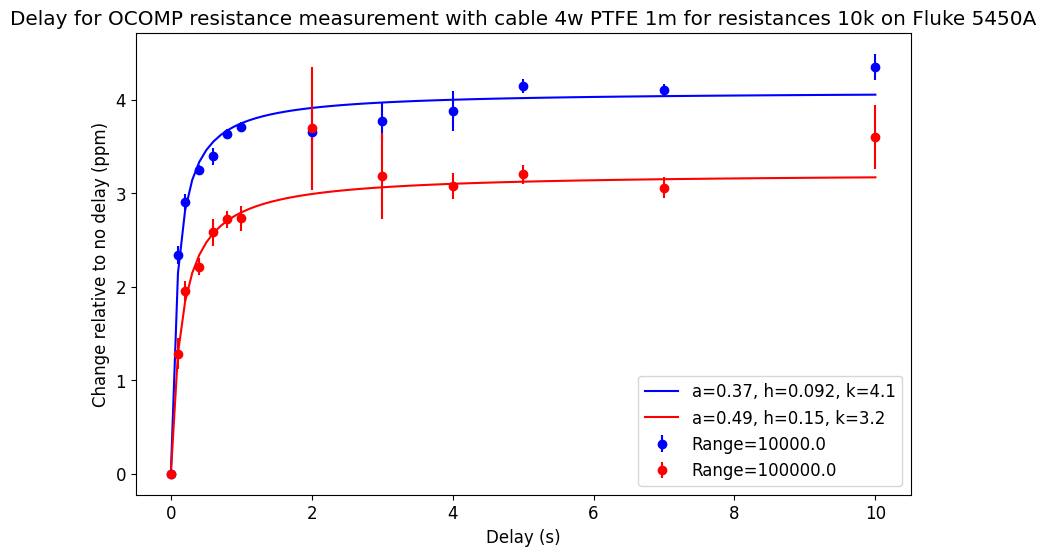

a     h     k  \
cable      dut_setting dut         ag3458a_2_range                     
4w PTFE 1m 10 kOhm     Fluke 5450A 10000.0          0.37  0.09  4.09   
                                   100000.0         0.49  0.15  3.22   

                                                    time (within 0.1 ppm)  
cable      dut_setting dut         ag3458a_2_range                         
4w PTFE 1m 10 kOhm     Fluke 5450A 10000.0                           3.65  
                                   100000.0                          4.72

In [30]:
res_delay_group2_10k_100k_comparison = res_delay_test_data_with_rel_group2[(res_delay_test_data_with_rel_group2.dut == 'Fluke 5450A') & (res_delay_test_data_with_rel_group2.dut_setting == '10 kOhm') & (res_delay_test_data_with_rel_group2.cable == '4w PTFE 1m')]
# Remove first set from every group, because it did not start at 0
#res_delay_group2_10k_100k_comparison_filtered = res_delay_group2_10k_100k_comparison.groupby('group').apply(lambda x: x.iloc[x.ag3458a_2_delay.to_numpy().reshape(-1).tolist().index(0):] if x.ag3458a_2_delay[0] != 0 else x).reset_index(drop=True)

res_delay_group2_10k_100k_comparison_grouped = res_delay_group2_10k_100k_comparison.groupby(['group', 'ag3458a_2_delay'], axis=0).agg({'rel_ag3458a_2_ohm_ppm': ['mean', 'std', 'sem', 'count'], 'dut': 'last', 'dut_setting': 'last', 'cable': 'last', 'ag3458a_2_range': 'last'}).reset_index()
res_delay_group2_10k_100k_comparison_fit_results_list = []
with do_delay_plot({'cable': '4w PTFE 1m', 'resistance_range': '10k on Fluke 5450A'}):
    res_delay_group2_10k_100k_comparison_10k_results = res_delay_group2_10k_100k_comparison_grouped[res_delay_group2_10k_100k_comparison_grouped['ag3458a_2_range']['last'] == 10000]
    fit_results = plot_and_fit_group(res_delay_group2_10k_100k_comparison_10k_results, color='blue', label_format='Range={range}', fit_function=reciprocal, fit_param_names=['a', 'h', 'k'])
    fit_results['group'] = res_delay_group2_10k_100k_comparison_10k_results['group'].iloc[0]
    res_delay_group2_10k_100k_comparison_fit_results_list.append(fit_results)
    
    res_delay_group2_10k_100k_comparison_100k_results = res_delay_group2_10k_100k_comparison_grouped[res_delay_group2_10k_100k_comparison_grouped['ag3458a_2_range']['last'] == 100000]
    fit_results = plot_and_fit_group(res_delay_group2_10k_100k_comparison_100k_results, color='red', label_format='Range={range}', fit_function=reciprocal, fit_param_names=['a', 'h', 'k'])
    fit_results['group'] = res_delay_group2_10k_100k_comparison_100k_results['group'].iloc[0]
    res_delay_group2_10k_100k_comparison_fit_results_list.append(fit_results)

res_delay_group2_10k_100k_comparison_fit_results = pd.DataFrame(columns=['group'] + ['a', 'h', 'k'], data=res_delay_group2_10k_100k_comparison_fit_results_list).set_index('group', drop=True)

display_fit_results(res_delay_group2_10k_100k_comparison_grouped, res_delay_group2_10k_100k_comparison_fit_results, 0.1, inv_reciprocal, ['a', 'h', 'k'])

#### Comparing guard -> shield to guard -> low + shield

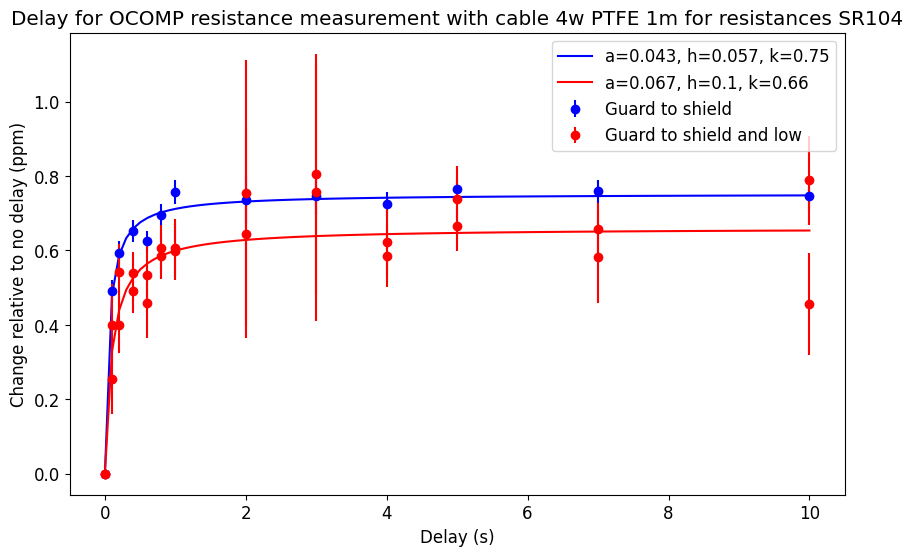

a  \
cable                                dut_setting dut   ag3458a_2_range         
4w PTFE 2m                           10 kOhm     SR104 10000.0          0.04   
4w PTFE 2m-guard-to-force-low-at-dut 10 kOhm     SR104 10000.0          0.07   
                                                       10000.0           NaN   

                                                                           h  \
cable                                dut_setting dut   ag3458a_2_range         
4w PTFE 2m                           10 kOhm     SR104 10000.0          0.06   
4w PTFE 2m-guard-to-force-low-at-dut 10 kOhm     SR104 10000.0          0.10   
                                                       10000.0           NaN   

                                                                           k  \
cable                                dut_setting dut   ag3458a_2_range         
4w PTFE 2m                           10 kOhm     SR104 10000.0          0.75   
4w PTFE 2m-guard-to-force-low-at-dut 10 kOhm     SR104 10000.0          0.66   
                                                       10000.0           NaN   

                                                                        time (within 0.1 ppm)  
cable                                dut_setting dut   ag3458a_2_range                         
4w PTFE 2m                           10 kOhm     SR104 10000.0                           0.37  
4w PTFE 2m-guard-to-force-low-at-dut 10 kOhm     SR104 10000.0                           0.57  
                                                       10000.0                            NaN

In [31]:
res_delay_group2_guard_to_low_comparison = res_delay_test_data_with_rel_group2[(res_delay_test_data_with_rel_group2.dut == 'SR104') & (res_delay_test_data_with_rel_group2.dut_setting == '10 kOhm') & (res_delay_test_data_with_rel_group2.cable.str.startswith('4w PTFE 2m'))]
# Remove first set from every group, because it did not start at 0
#res_delay_group2_guard_to_low_comparison_filtered = res_delay_group2_guard_to_low_comparison.groupby('group').apply(lambda x: x.iloc[x.ag3458a_2_delay.to_numpy().reshape(-1).tolist().index(0):] if x.ag3458a_2_delay[0] != 0 else x).reset_index(drop=True)

res_delay_group2_guard_to_low_comparison_grouped = res_delay_group2_guard_to_low_comparison.groupby(['group', 'ag3458a_2_delay'], axis=0).agg({'rel_ag3458a_2_ohm_ppm': ['mean', 'std', 'sem', 'count'], 'dut': 'last', 'dut_setting': 'last', 'cable': 'last', 'ag3458a_2_range': 'last'}).reset_index()
res_delay_group2_guard_to_low_comparison_fit_results_list = []
with do_delay_plot({'cable': '4w PTFE 1m', 'resistance_range': 'SR104'}):
    res_delay_group2_guard_to_low_comparison_guard_to_shield_results = res_delay_group2_guard_to_low_comparison_grouped[res_delay_group2_guard_to_low_comparison_grouped['cable']['last'] == '4w PTFE 2m']
    fit_results = plot_and_fit_group(res_delay_group2_guard_to_low_comparison_guard_to_shield_results, color='blue', label_format='Guard to shield', fit_function=reciprocal, fit_param_names=['a', 'h', 'k'])
    fit_results['group'] = res_delay_group2_guard_to_low_comparison_guard_to_shield_results['group'].iloc[0]
    res_delay_group2_guard_to_low_comparison_fit_results_list.append(fit_results)
    
    res_delay_group2_guard_to_low_comparison_guard_to_lo_and_shield_results = res_delay_group2_guard_to_low_comparison_grouped[res_delay_group2_guard_to_low_comparison_grouped['cable']['last'] == '4w PTFE 2m-guard-to-force-low-at-dut']
    fit_results = plot_and_fit_group(res_delay_group2_guard_to_low_comparison_guard_to_lo_and_shield_results, color='red', label_format='Guard to shield and low', fit_function=reciprocal, fit_param_names=['a', 'h', 'k'])
    fit_results['group'] = res_delay_group2_guard_to_low_comparison_guard_to_lo_and_shield_results['group'].iloc[0]
    res_delay_group2_guard_to_low_comparison_fit_results_list.append(fit_results)

res_delay_group2_guard_to_low_comparison_fit_results = pd.DataFrame(columns=['group'] + ['a', 'h', 'k'], data=res_delay_group2_guard_to_low_comparison_fit_results_list).set_index('group', drop=True)

display_fit_results(res_delay_group2_guard_to_low_comparison_grouped, res_delay_group2_guard_to_low_comparison_fit_results, 0.1, inv_reciprocal, ['a', 'h', 'k'])

In [32]:
res_delay_group2_guard_to_low_comparison_guard_to_lo_and_shield_results

group ag3458a_2_delay rel_ag3458a_2_ohm_ppm                            \
                                          mean       std       sem count   
0      4             0.0              0.000000  0.000000  0.000000    31   
1      4             0.1              0.400997  0.599750  0.107718    31   
2      4             0.2              0.542221  0.415064  0.074548    31   
3      4             0.4              0.491319  0.326240  0.058595    31   
4      4             0.6              0.457863  0.514094  0.093860    30   
5      4             0.8              0.606995  0.340508  0.062168    30   
6      4             1.0              0.607124  0.437875  0.078645    31   
7      4             2.0              0.644761  1.539930  0.281152    30   
8      4             3.0              0.806127  1.767889  0.322771    30   
9      4             4.0              0.584961  0.450406  0.083638    29   
10     4             5.0              0.664995  0.350787  0.065140    29   
11     4             7.0              0.583444  0.672472  0.124875    29   
12     4            10.0              0.789235  0.643286  0.119455    29   
26     6             0.0              0.000000  0.000000  0.000000    34   
27     6             0.1              0.253733  0.541870  0.092930    34   
28     6             0.2              0.400261  0.439441  0.075364    34   
29     6             0.4              0.539201  0.338478  0.058048    34   
30     6             0.6              0.535024  0.564641  0.096835    34   
31     6             0.8              0.584642  0.354152  0.060737    34   
32     6             1.0              0.598171  0.448912  0.076988    34   
33     6             2.0              0.755081  2.088257  0.358133    34   
34     6             3.0              0.756539  1.982791  0.345160    33   
35     6             4.0              0.622267  0.529991  0.092260    33   
36     6             5.0              0.739690  0.494803  0.086134    33   
37     6             7.0              0.658418  0.397768  0.069243    33   
38     6            10.0              0.456269  0.793473  0.138126    33   

      dut dut_setting                                 cable ag3458a_2_range  
     last        last                                  last            last  
0   SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
1   SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
2   SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
3   SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
4   SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
5   SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
6   SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
7   SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
8   SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
9   SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
10  SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
11  SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
12  SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
26  SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
27  SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
28  SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
29  SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
30  SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
31  SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
32  SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
33  SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
34  SR104     10 kOhm  4w PTFE 2m-guard-to-force-low-at-dut         10000.0  
35

In [33]:
res_delay_test_data_with_rel_group2.groupby('group').count()

,dut,dut_setting,cable,ag3458a_2_ohm,temp_2,last_acal_2,last_acal_2_cal72,ag3458a_2_range,ag3458a_2_delay,replicate,rel_ag3458a_2_ohm_ppm
group,,,,,,,,,,,
1,343,343,343,343,22,343,343,343,343,343,343
2,449,449,449,449,29,449,449,449,449,449,449
3,387,387,387,387,25,387,387,387,387,387,387
4,391,391,391,391,25,391,391,391,391,391,391
5,649,649,649,649,41,649,649,649,649,649,649
6,437,437,437,437,28,437,437,437,437,437,437
7,321,321,321,321,20,321,321,321,321,321,321
8,454,454,454,454,29,454,454,454,454,454,454
9,1361,1361,1361,1361,56,1361,1361,1361,1361,1361,1361


### Another round of measurements with shorter delay times and guard to low + shield

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


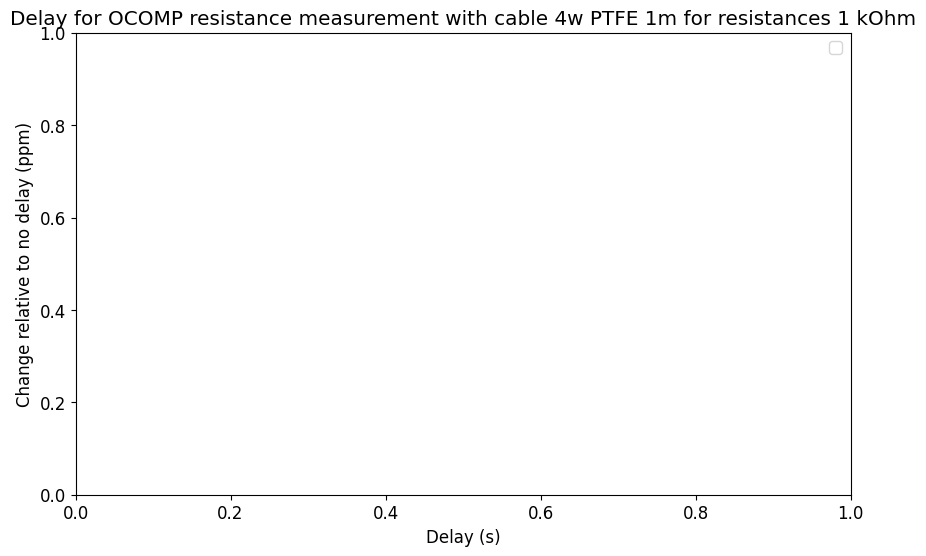

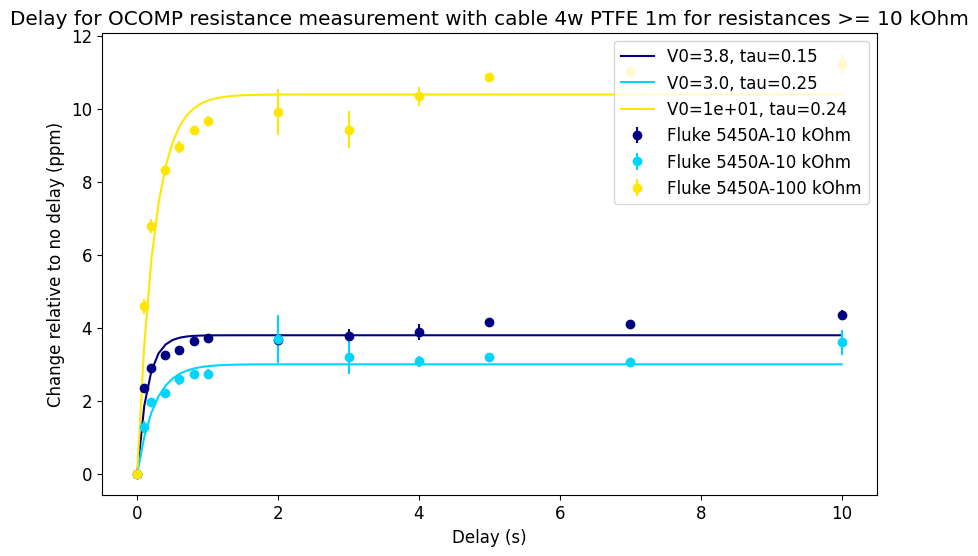

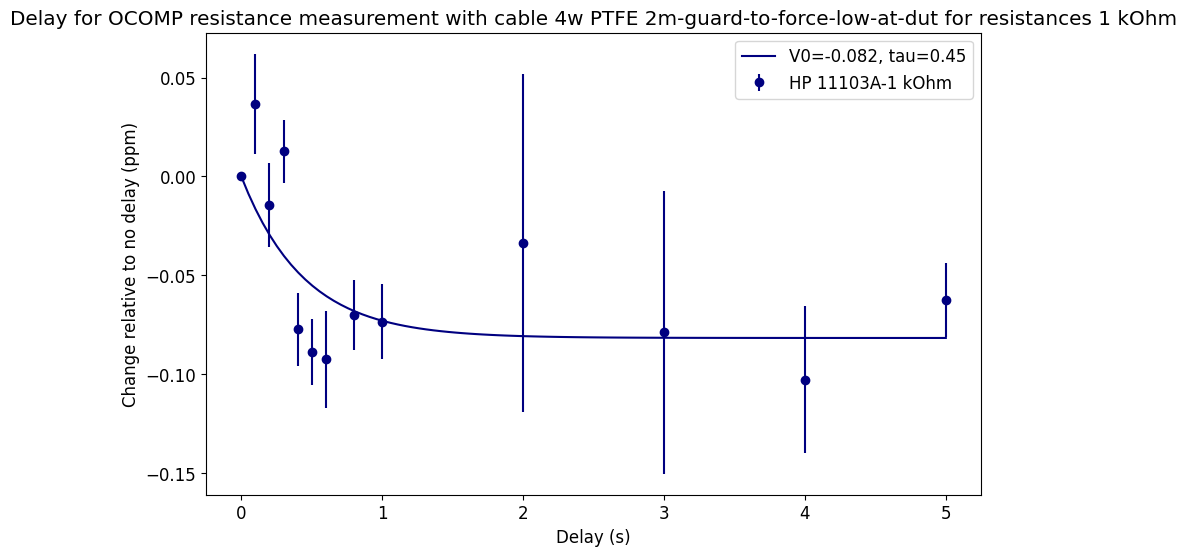

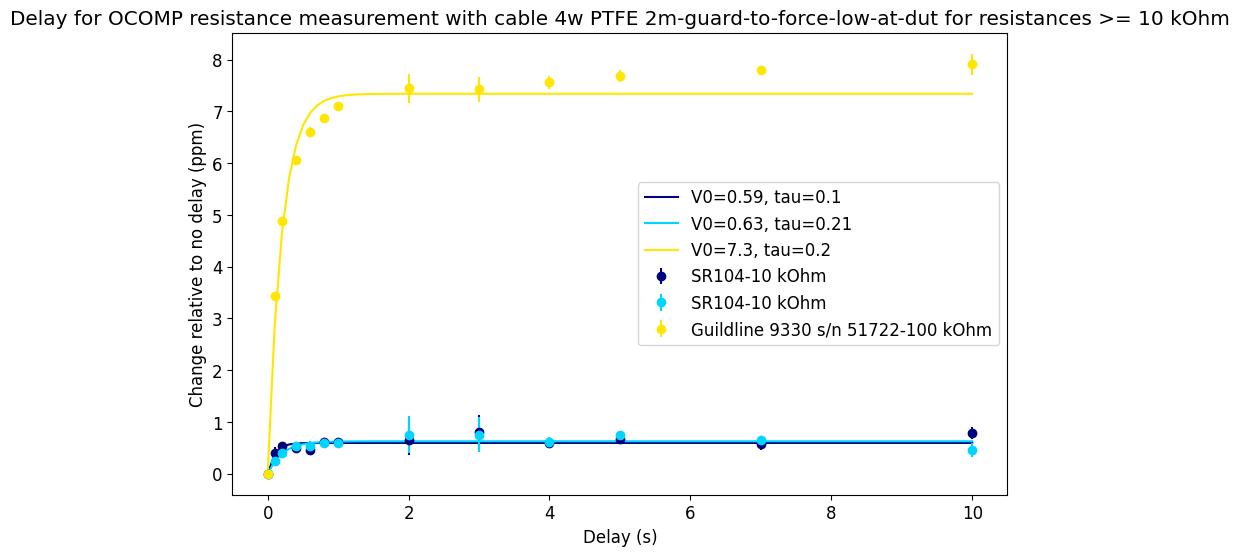

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


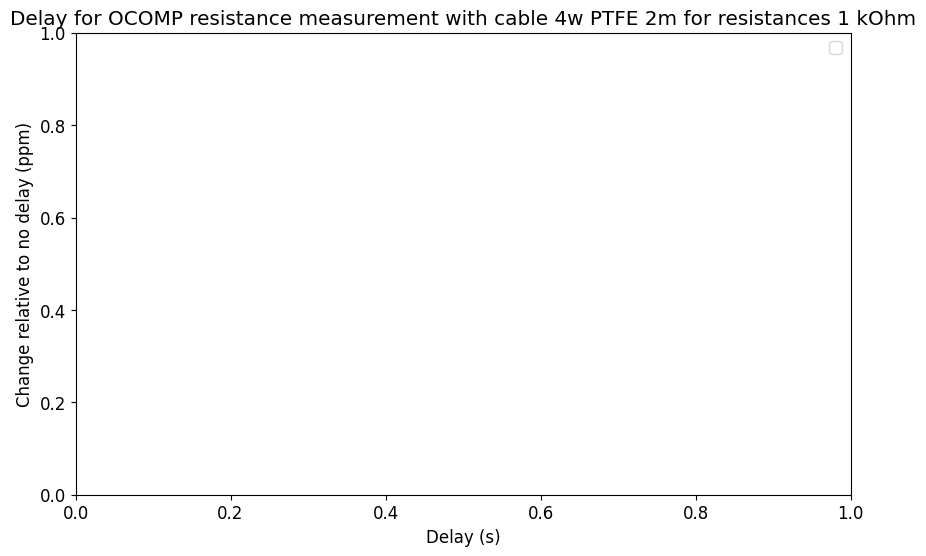

/home/alson/shared/projects/personal/electronics/t&m/automation/data-analysis/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


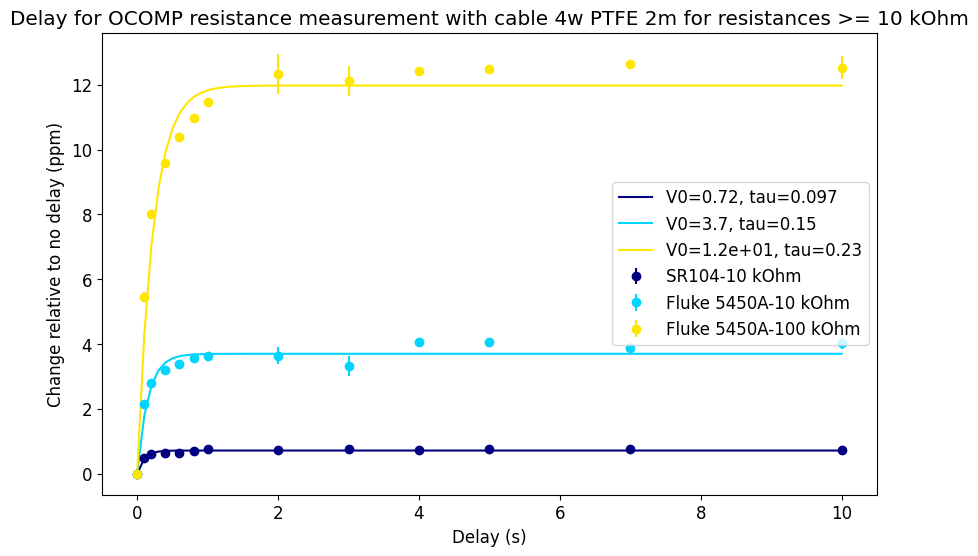

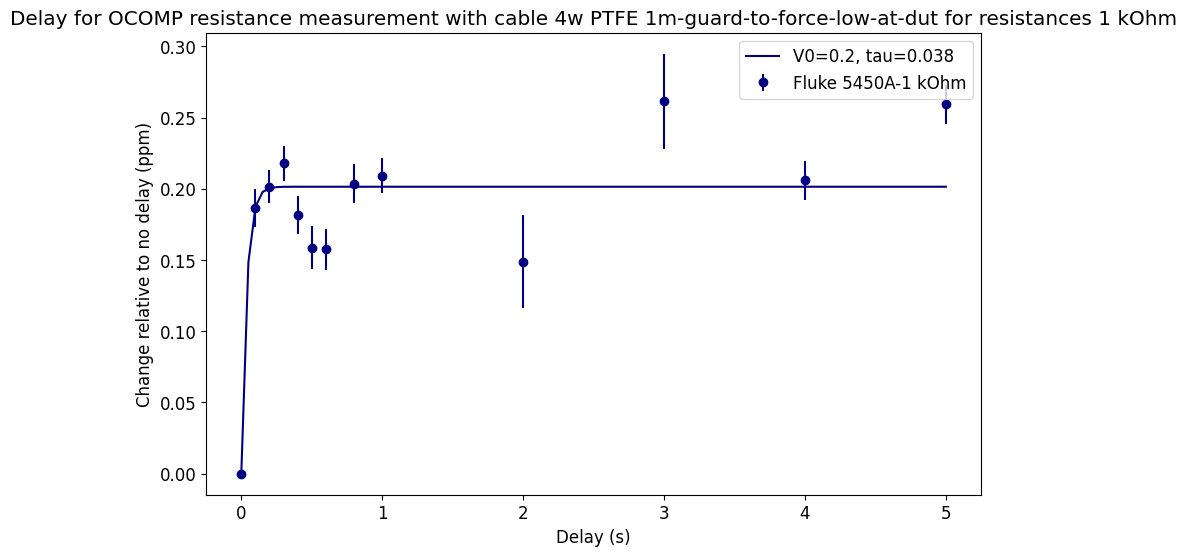

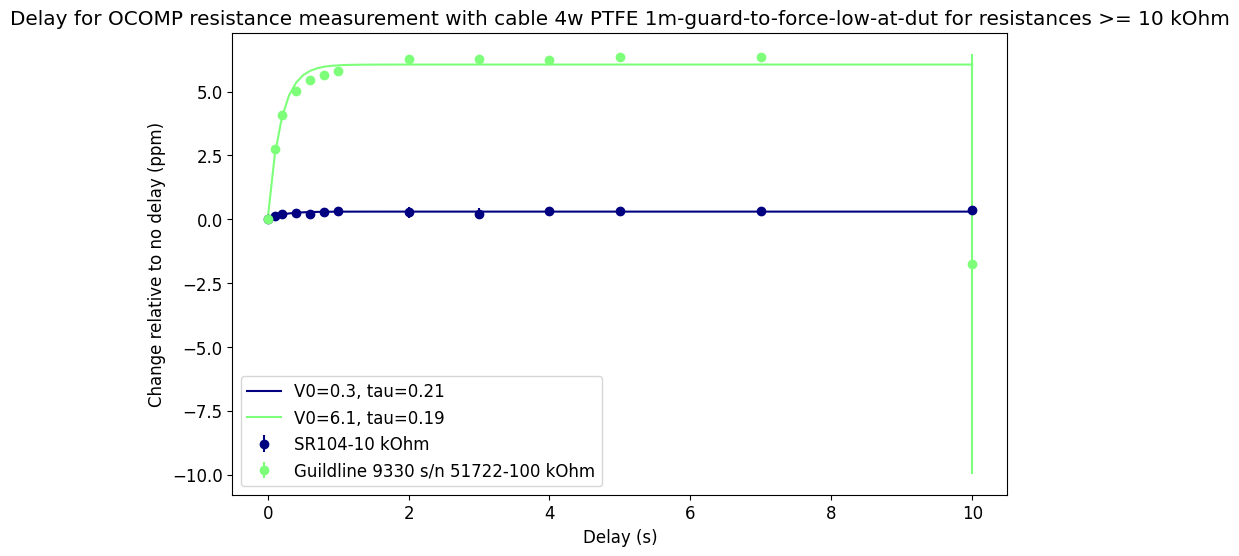

In [34]:
#res_delay_test_data_group2['group'] = (res_delay_test_data_group2[['dut', 'dut_setting', 'cable', 'ag3458a_2_range']].apply(tuple, axis=1) != res_delay_test_data_group2[['dut', 'dut_setting', 'cable', 'ag3458a_2_range']].shift().apply(tuple, axis=1)).cumsum()
#res_delay_test_data_group2['replicate'] = (res_delay_test_data_group2.ag3458a_2_delay == 0).cumsum()
#res_delay_test_data_with_rel_group2 = res_delay_test_data_group2.groupby('replicate').apply(partial(sub_first_value_from_every_value, 'ag3458a_2_ohm'))
delay_test_results_group2, fit_results_group2 = plot_and_fit_delay_results(res_delay_test_data_with_rel_group2)
delay_test_results_group2[['dut', 'dut_setting', 'cable', 'ag3458a_2_delay', 'rel_ag3458a_2_ohm_ppm']].sort_values([('cable', 'last'), ('dut_setting', 'last'), ('dut', 'last')]).to_csv('measurement-tests-delay-test-results.csv')

In [35]:
display_fit_results(delay_test_results_group2, fit_results_group2)

V0  \
cable                                dut_setting dut                      ag3458a_2_range          
4w PTFE 1m                           10 kOhm     Fluke 5450A              10000.0           3.79   
                                                                          100000.0          3.00   
                                     100 kOhm    Fluke 5450A              100000.0         10.39   
4w PTFE 1m-guard-to-force-low-at-dut 1 kOhm      Fluke 5450A              1000.0            0.20   
                                     10 kOhm     SR104                    10000.0           0.30   
                                     100 kOhm    Guildline 9330 s/n 51722 100000.0          6.06   
4w PTFE 2m                           10 kOhm     Fluke 5450A              10000.0           3.70   
                                                 SR104                    10000.0           0.72   
                                     100 kOhm    Fluke 5450A              100000.0         11.97   
4w PTFE 2m-guard-to-force-low-at-dut 1 kOhm      HP 11103A                1000.0           -0.08   
                                     10 kOhm     SR104                    10000.0           0.59   
                                                                          10000.0           0.63   
                                     100 kOhm    Guildline 9330 s/n 51722 100000.0          7.34   

                                                                                            tau  \
cable                                dut_setting dut                      ag3458a_2_range         
4w PTFE 1m                           10 kOhm     Fluke 5450A              10000.0          0.15   
                                                                          100000.0         0.25   
                                     100 kOhm    Fluke 5450A              100000.0         0.24   
4w PTFE 1m-guard-to-force-low-at-dut 1 kOhm      Fluke 5450A              1000.0           0.04   
                                     10 kOhm     SR104                    10000.0          0.21   
                                     100 kOhm    Guildline 9330 s/n 51722 100000.0         0.19   
4w PTFE 2m                           10 kOhm     Fluke 5450A              10000.0          0.15   
                                                 SR104                    10000.0          0.10   
                                     100 kOhm    Fluke 5450A              100000.0         0.23   
4w PTFE 2m-guard-to-force-low-at-dut 1 kOhm      HP 11103A                1000.0           0.45   
                                     10 kOhm     SR104                    10000.0          0.10   
                                                                          10000.0          0.21   
                                     100 kOhm    Guildline 9330 s/n 51722 100000.0         0.20   

                                                                                           time (within 0.05 ppm)  
cable                                dut_setting dut                      ag3458a_2_range                          
4w PTFE 1m                           10 kOhm     Fluke 5450A              10000.0                            0.65  
                                                                          100000.0                           1.01  
                                     100 kOhm    Fluke 5450A              100000.0                           1.30  
4w PTFE 1m-guard-to-force-low-at-dut 1 kOhm      Fluke 5450A              1000.0                             0.05  
                                     10 kOhm     SR104                    10000.0                            0.38  
                                     100 kOhm    Guildline 9330 s/n 51722 100000.0                           0.90  
4w PTFE 2m                           10 kOhm     Fluke 5450A              10000.0                            0.66  
                                                 SR104         

<Axes: >

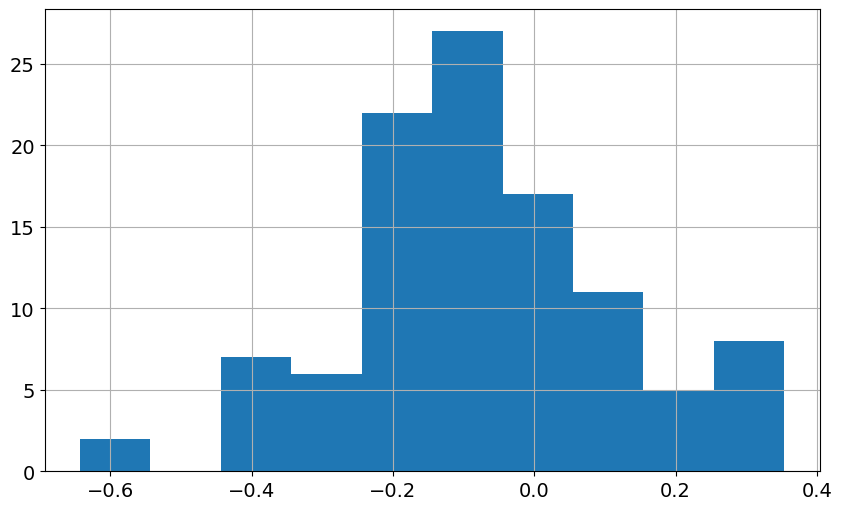

In [36]:
res_delay_test_data_with_rel_group2[(res_delay_test_data_with_rel_group2.dut == 'HP 11103A') & (res_delay_test_data_with_rel_group2.ag3458a_2_delay == 1)]['rel_ag3458a_2_ohm_ppm'].hist()

In [37]:
group2_stds = res_delay_test_data_group2.groupby(['dut', 'dut_setting', 'cable', 'ag3458a_2_range', 'ag3458a_2_delay']).agg({'ag3458a_2_ohm': ['std', 'mean']})
group2_stds['ag3458a_2_ohm_rel'] = group2_stds['ag3458a_2_ohm']['std'] / group2_stds['ag3458a_2_ohm']['mean']
group2_stds[group2_stds.ag3458a_2_ohm_rel > 1e-6]

ag3458a_2_ohm  \
                                                                                                                    std   
dut                      dut_setting cable                                ag3458a_2_range ag3458a_2_delay                 
Fluke 5450A              10 kOhm     4w PTFE 1m                           10000.0         2.0                  0.014282   
                                                                                          3.0                  0.010063   
                                                                          100000.0        2.0                  0.037560   
                                                                                          3.0                  0.024991   
                                                                                          10.0                 0.021440   
                                     4w PTFE 2m                           10000.0         2.0                  0.013321   
                                                                                          3.0                  0.015352   
                         100 kOhm    4w PTFE 1m                           100000.0        0.1                  0.138748   
                                                                                          2.0                  0.352974   
                                                                                          3.0                  0.268867   
                                                                                          4.0                  0.129321   
                                                                                          10.0                 0.159017   
                                     4w PTFE 2m                           100000.0        2.0                  0.358799   
                                                                                          3.0                  0.266890   
                                                                                          10.0                 0.218470   
Guildline 9330 s/n 51722 100 kOhm    4w PTFE 1m-guard-to-force-low-at-dut 100000.0        10.0                 4.419229   
                                     4w PTFE 2m-guard-to-force-low-at-dut 100000.0        2.0                  0.214507   
                                                                                          3.0                  0.171369   
                                                                                          10.0                 0.145006   
SR104                    10 kOhm     4w PTFE 1m-guard-to-force-low-at-dut 10000.0         2.0                  0.016322   
                                                                                          3.0                  0.015397   
                                                                                          10.0                 0.010172   
                                     4w PTFE 2m-guard-to-force-low-at-dut 10000.0         2.0                  0.019231   
                                                                                          3.0                  0.019138   

                                                                                                                          \
                                                                                                                    mean   
dut                      dut_setting cable                                ag3458a_2_range ag3458a_2_delay                  
Fluke 5450A              10 kOhm     4w PTFE 1m                           10000.0         2.0               10000.479276   
                                                                                          3.0               10000.479839   
                                                                          100000.0        2.0               10000.489767   
                                        

In [38]:
res_delay_test_data_with_rel_group2[(res_delay_test_data_with_rel_group2.dut == 'HP 11103A')].groupby('ag3458a_2_delay').agg({'ag3458a_2_ohm': ['std', 'mean']})

ag3458a_2_ohm             
                          std         mean
ag3458a_2_delay                           
0.0                  0.000568  1000.021872
0.1                  0.000548  1000.021908
0.2                  0.000580  1000.021857
0.3                  0.000539  1000.021884
0.4                  0.000569  1000.021794
0.5                  0.000567  1000.021783
0.6                  0.000583  1000.021779
0.8                  0.000576  1000.021801
1.0                  0.000578  1000.021798
2.0                  0.000987  1000.021838
3.0                  0.000892  1000.021793
4.0                  0.000742  1000.021769
5.0                  0.000547  1000.021809

In [39]:
res_delay_test_data_with_rel_group2[(res_delay_test_data_with_rel_group2.dut == 'HP 11103A') & (res_delay_test_data_with_rel_group2.ag3458a_2_delay == 1)]['ag3458a_2_ohm'].mean()

1000.0217981619047

In [40]:
0.0005759860666433831 / 1000.0218008867924
 

5.759735099100981e-07

In [41]:
res_delay_test_data_with_rel_group2[(res_delay_test_data_with_rel_group2.dut == 'HP 11103A') & (res_delay_test_data_with_rel_group2.ag3458a_2_delay == 1)]['rel_ag3458a_2_ohm_ppm'].std()


0.1952737772693288

In [42]:
res_delay_test_data_with_rel_group2[(res_delay_test_data_with_rel_group2.dut == 'HP 11103A') & (res_delay_test_data_with_rel_group2.ag3458a_2_delay == 2)]['rel_ag3458a_2_ohm_ppm'].std()

0.8705775505959474

In [43]:
res_delay_test_data_with_rel_group2[(res_delay_test_data_with_rel_group2.dut == 'HP 11103A') & (res_delay_test_data_with_rel_group2.ag3458a_2_delay == 1)]['rel_ag3458a_2_ohm_ppm'].std()

0.1952737772693288

In [44]:
res_delay_test_data_with_rel_group2[(res_delay_test_data_with_rel_group2.dut == 'HP 11103A') & (res_delay_test_data_with_rel_group2.ag3458a_2_delay == 1)]['rel_ag3458a_2_ohm_ppm']

replicate      
268        3439   -0.327993
269        3452    0.048999
270        3465   -0.020000
271        3478   -0.120997
272        3491   -0.269994
                     ...   
368        4739   -0.369992
369        4752   -0.222995
370        4765   -0.234995
371        4778   -0.026999
372        4791   -0.175996
Name: rel_ag3458a_2_ohm_ppm, Length: 105, dtype: float64

In [45]:
res_delay_test_data_with_rel_group2[(res_delay_test_data_with_rel_group2.dut == 'HP 11103A') & (res_delay_test_data_with_rel_group2.ag3458a_2_delay == 1)]['ag3458a_2_ohm']

replicate      
268        3439    1000.022111
269        3452    1000.022560
270        3465    1000.022266
271        3478    1000.022306
272        3491    1000.022113
                      ...     
368        4739    1000.021683
369        4752    1000.021440
370        4765    1000.021490
371        4778    1000.021611
372        4791    1000.021671
Name: ag3458a_2_ohm, Length: 105, dtype: float64

In [46]:

res_delay_test_data_group2.groupby('group').apply(lambda x: x.iloc[0])

,dut,dut_setting,cable,ag3458a_2_ohm,temp_2,last_acal_2,last_acal_2_cal72,ag3458a_2_range,ag3458a_2_delay,group,replicate
group,,,,,,,,,,,
1,Fluke 5450A,10 kOhm,4w PTFE 1m,10000.476720,NaN,2022-09-26T19:15:43.975634,keep,10000.0,1.0,1,0
2,Fluke 5450A,10 kOhm,4w PTFE 1m,10000.468920,NaN,2022-09-27T01:19:22.761659,keep,100000.0,1.0,2,26
3,Fluke 5450A,100 kOhm,4w PTFE 1m,100005.110500,NaN,2022-09-27T01:19:22.761659,keep,100000.0,1.0,3,61
4,SR104,10 kOhm,4w PTFE 2m-guard-to-force-low-at-dut,10000.089030,NaN,2022-09-27T16:10:18.951181,999.480753E-03,10000.0,1.0,4,91
5,SR104,10 kOhm,4w PTFE 2m,10000.090710,NaN,2022-09-27T23:22:18.401203,keep,10000.0,1.0,5,122
6,SR104,10 kOhm,4w PTFE 2m-guard-to-force-low-at-dut,10000.095890,49.2,2022-09-27T23:22:18.401203,keep,10000.0,1.0,6,172
7,Fluke 5450A,10 kOhm,4w PTFE 2m,10000.503200,NaN,2022-09-27T23:22:18.401203,keep,10000.0,1.0,7,206
8,Fluke 5450A,100 kOhm,4w PTFE 2m,100005.045900,NaN,2022-09-29T00:34:34.264212,keep,100000.0,1.0,8,232
9,HP 11103A,1 kOhm,4w PTFE 2m-guard-to-force-low-at-dut,1000.022087,48.2,2022-09-29T08:29:06.929302,999.480749E-03,1000.0,1.0,9,267


# DC Voltage
## HP 3458A #2 DCV ACAL (since it has a lower LTZ1000 setpoint)

In [47]:
_, data = read_data(['ks3458a-dcv-tc-log-w-acal.csv'])
ks3458a_dc_w_acal = data['ks3458a-dcv-tc-log-w-acal.csv']

In [48]:
def clean_dcv_tc(data, ks3458a_number):
    cleaned = data.copy()
    cleaned[f'temp_{ks3458a_number}_interpolated'] = cleaned[f'temp_{ks3458a_number}'].interpolate()
    cleaned[f'dcv_{ks3458a_number}_ppm'] = (cleaned[f'ag3458a_{ks3458a_number}_dcv'] - 10) / 10 * 1e6
    return cleaned

def plot_dcv_tc(data, ks3458a_number):
    fit_data = data.dropna()
    regressor = LinearRegression()
    ks3458a_temp_column = f'temp_{ks3458a_number}_interpolated'
    ppm_column = f'dcv_{ks3458a_number}_ppm'
    regressor.fit(fit_data[ks3458a_temp_column].values.reshape(-1, 1), fit_data[ppm_column])
    temps = np.arange(data[ks3458a_temp_column].min(), data[ks3458a_temp_column].max(), 0.1)
    plt.title('LTZ1000 temperature coefficient')
    plt.plot(data[ks3458a_temp_column], data[ppm_column], 'o', label='Measurement at ACAL')
    plt.plot(temps, regressor.predict(temps.reshape(-1, 1)), label="Linear fit")
    plt.legend()
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Deviation from 10V (uV/V)')
    plt.text(data[ks3458a_temp_column].min(), data[ppm_column].min(), f"TC = {regressor.coef_[0]:.2e} ppm/°C")

def process_dcv_tc(data, ks3458a_number):
    cleaned = clean_dcv_tc(data, ks3458a_number)
    only_acal = filter_acal_points(cleaned, ks3458a_number)
    plot_dcv_tc(only_acal, ks3458a_number)

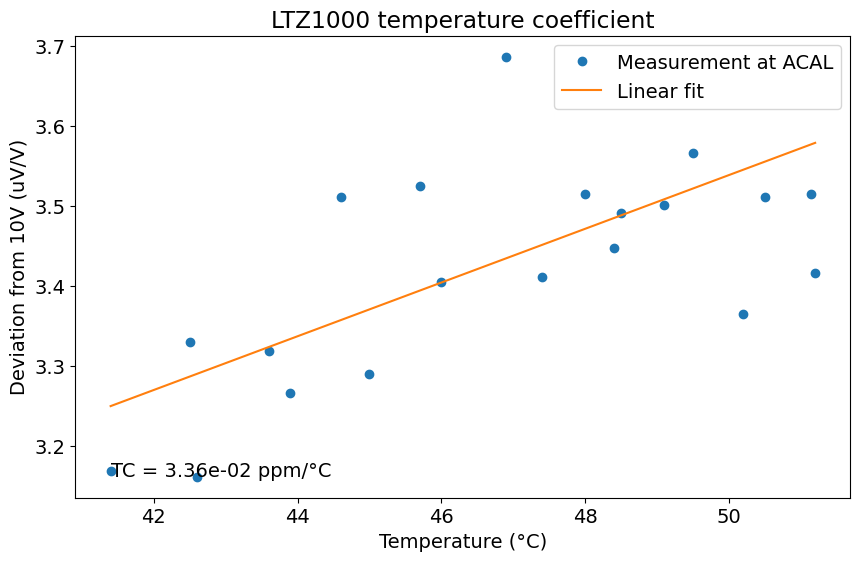

In [51]:
process_dcv_tc(ks3458a_dc_w_acal, 2)

## Comparing the effect of the 3458A guard button on DCV measurements

Trigger was MM2022 where we noticed a -2 ppm difference when the guard was connected to the lo input lead of a F7000 reference and the guard button on the 3458A was set to "LO" instead of "OPEN". For this test I checked series of measurements alternatingly with guard switch OPEN and LO, but guard lead connected to low lead at F7001 at all times. I checked both negative and positive polarity.

In [ ]:
ag3458a1_guard = pd.read_csv(find_file("ks3458a1-dcv-guard-test.csv"), parse_dates=['datetime'])
ag3458a2_guard = pd.read_csv(find_file("ks3458a-dcv-guard-test.csv"), parse_dates=['datetime'])

In [ ]:
ag3458a1_guard

,datetime,dut,dut_setting,guard_setting,ag3458a_1_dcv,temp_1,last_acal_1,last_acal_1_cal72
0,2022-09-21 20:47:25.548800,F7001bat,10 V,open,9.999944,NaN,2022-09-21T20:46:32.977680,1.00073793E+00
1,2022-09-21 20:47:29.654260,F7001bat,10 V,open,9.999943,NaN,2022-09-21T20:46:32.977680,1.00073793E+00
2,2022-09-21 20:47:33.750037,F7001bat,10 V,open,9.999944,NaN,2022-09-21T20:46:32.977680,1.00073793E+00
3,2022-09-21 20:47:37.847339,F7001bat,10 V,open,9.999943,NaN,2022-09-21T20:46:32.977680,1.00073793E+00
4,2022-09-21 20:47:41.946119,F7001bat,10 V,open,9.999944,NaN,2022-09-21T20:46:32.977680,1.00073793E+00
...,...,...,...,...,...,...,...,...
1381,2022-09-26 23:35:39.391634,F732a1,10 V,"Lead to lo, open",10.000184,NaN,2022-09-26T22:21:33.419868,keep
1382,2022-09-26 23:35:43.494376,F732a1,10 V,"Lead to lo, open",10.000185,NaN,2022-09-26T22:21:33.419868,keep
1383,2022-09-26 23:35:47.599932,F732a1,10 V,"Lead to lo, open",10.000185,NaN,2022-09-26T22:21:33.419868,keep
1384,2022-09-26 23:35:51.696942,F732a1,10 V,"Lead to lo, open",10.000185,NaN,2022-09-26T22:21:33.419868,keep


In [ ]:
ag3458a1_guard['group'] = (ag3458a1_guard[['dut', 'dut_setting', 'guard_setting']].apply(tuple, axis=1) != ag3458a1_guard[['dut', 'dut_setting', 'guard_setting']].shift().apply(tuple, axis=1)).cumsum().rename('group')
ag3458a1_guard = ag3458a1_guard[ag3458a1_guard.datetime > pd.Timestamp(2022,9,21,22)]
ag3458a2_guard['group'] = (ag3458a2_guard[['dut', 'dut_setting', 'guard_setting']].apply(tuple, axis=1) != ag3458a2_guard[['dut', 'dut_setting', 'guard_setting']].shift().apply(tuple, axis=1)).cumsum().rename('group')
ag3458a2_guard = ag3458a2_guard[ag3458a2_guard.datetime > pd.Timestamp(2022,9,21,22,10)]

In [ ]:
ag3458a1_guard_grouped = ag3458a1_guard.groupby('group').agg({'dut': 'last', 'dut_setting': 'last', 'guard_setting': 'last', 'ag3458a_1_dcv': ['mean', 'std', 'count']})
ag3458a2_guard_grouped = ag3458a2_guard.groupby('group').agg({'dut': 'last', 'dut_setting': 'last', 'guard_setting': 'last', 'ag3458a_2_dcv': ['mean', 'std', 'count']})

Text(0.5, 1.0, '3458A #1 guard switch effect against F7001')

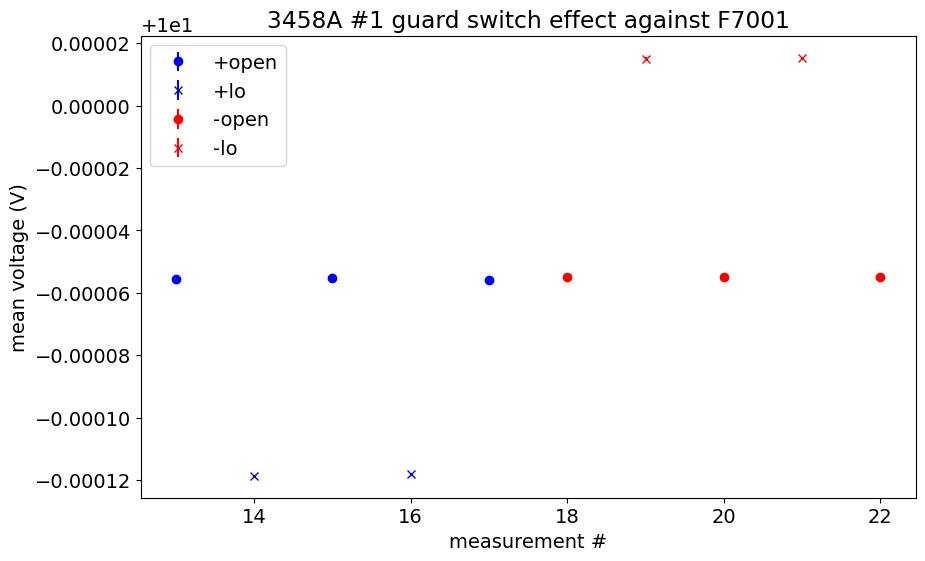

In [ ]:

ag3458a1_guard_grouped_pos_open = ag3458a1_guard_grouped[(ag3458a1_guard_grouped['dut_setting']['last'] == '10 V') & (ag3458a1_guard_grouped['guard_setting']['last'] == 'open')]
ag3458a1_guard_grouped_pos_lo = ag3458a1_guard_grouped[(ag3458a1_guard_grouped['dut_setting']['last'] == '10 V') & (ag3458a1_guard_grouped['guard_setting']['last'] == 'lo')]
ag3458a1_guard_grouped_neg_open = ag3458a1_guard_grouped[(ag3458a1_guard_grouped['dut_setting']['last'] == '-10 V') & (ag3458a1_guard_grouped['guard_setting']['last'] == 'open')]
ag3458a1_guard_grouped_neg_lo = ag3458a1_guard_grouped[(ag3458a1_guard_grouped['dut_setting']['last'] == '-10 V') & (ag3458a1_guard_grouped['guard_setting']['last'] == 'lo')]

plt.errorbar(ag3458a1_guard_grouped_pos_open.index, np.abs(ag3458a1_guard_grouped_pos_open['ag3458a_1_dcv']['mean']), yerr=ag3458a1_guard_grouped_pos_open['ag3458a_1_dcv']['std'], fmt='o', c='blue', label='+open')
plt.errorbar(ag3458a1_guard_grouped_pos_lo.index, np.abs(ag3458a1_guard_grouped_pos_lo['ag3458a_1_dcv']['mean']), yerr=ag3458a1_guard_grouped_pos_lo['ag3458a_1_dcv']['std'], fmt='x', c='blue', label='+lo')
plt.errorbar(ag3458a1_guard_grouped_neg_open.index, np.abs(ag3458a1_guard_grouped_neg_open['ag3458a_1_dcv']['mean']), yerr=ag3458a1_guard_grouped_neg_open['ag3458a_1_dcv']['std'], fmt='o', c='red', label='-open')
plt.errorbar(ag3458a1_guard_grouped_neg_lo.index, np.abs(ag3458a1_guard_grouped_neg_lo['ag3458a_1_dcv']['mean']), yerr=ag3458a1_guard_grouped_neg_lo['ag3458a_1_dcv']['std'], fmt='x', c='red', label='-lo')
plt.legend()
plt.xlabel('measurement #')
plt.ylabel('mean voltage (V)')
plt.title('3458A #1 guard switch effect against F7001')

Text(0.5, 1.0, '3458A #2 guard switch effect')

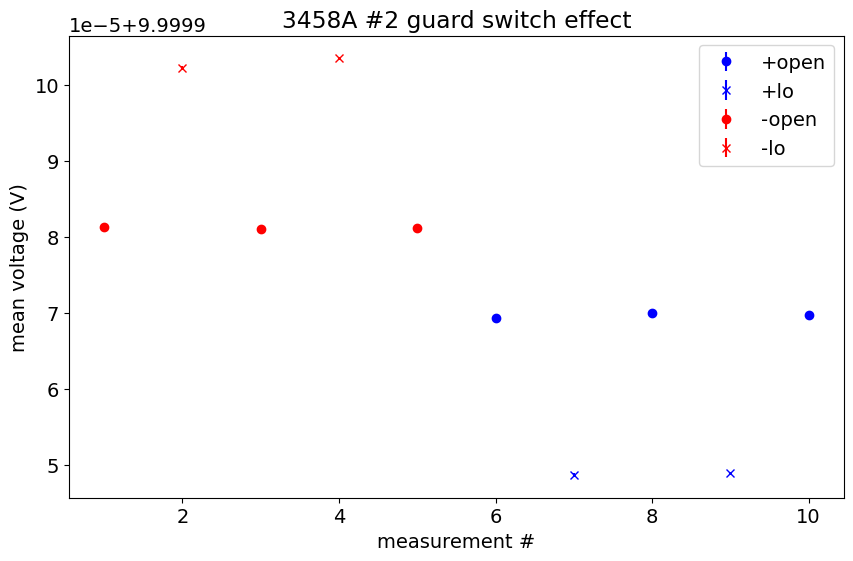

In [ ]:

ag3458a2_guard_grouped_pos_open = ag3458a2_guard_grouped[(ag3458a2_guard_grouped['dut_setting']['last'] == '10 V') & (ag3458a2_guard_grouped['guard_setting']['last'] == 'open')]
ag3458a2_guard_grouped_pos_lo = ag3458a2_guard_grouped[(ag3458a2_guard_grouped['dut_setting']['last'] == '10 V') & (ag3458a2_guard_grouped['guard_setting']['last'] == 'lo')]
ag3458a2_guard_grouped_neg_open = ag3458a2_guard_grouped[(ag3458a2_guard_grouped['dut_setting']['last'] == '-10 V') & (ag3458a2_guard_grouped['guard_setting']['last'] == 'open')]
ag3458a2_guard_grouped_neg_lo = ag3458a2_guard_grouped[(ag3458a2_guard_grouped['dut_setting']['last'] == '-10 V') & (ag3458a2_guard_grouped['guard_setting']['last'] == 'lo')]

plt.errorbar(ag3458a2_guard_grouped_pos_open.index, np.abs(ag3458a2_guard_grouped_pos_open['ag3458a_2_dcv']['mean']), yerr=ag3458a2_guard_grouped_pos_open['ag3458a_2_dcv']['std'], fmt='o', c='blue', label='+open')
plt.errorbar(ag3458a2_guard_grouped_pos_lo.index, np.abs(ag3458a2_guard_grouped_pos_lo['ag3458a_2_dcv']['mean']), yerr=ag3458a2_guard_grouped_pos_lo['ag3458a_2_dcv']['std'], fmt='x', c='blue', label='+lo')
plt.errorbar(ag3458a2_guard_grouped_neg_open.index, np.abs(ag3458a2_guard_grouped_neg_open['ag3458a_2_dcv']['mean']), yerr=ag3458a2_guard_grouped_neg_open['ag3458a_2_dcv']['std'], fmt='o', c='red', label='-open')
plt.errorbar(ag3458a2_guard_grouped_neg_lo.index, np.abs(ag3458a2_guard_grouped_neg_lo['ag3458a_2_dcv']['mean']), yerr=ag3458a2_guard_grouped_neg_lo['ag3458a_2_dcv']['std'], fmt='x', c='red', label='-lo')
plt.legend()
plt.xlabel('measurement #')
plt.ylabel('mean voltage (V)')
plt.title('3458A #2 guard switch effect')

In [ ]:
ag3458a1_guard_grouped[ag3458a1_guard_grouped['dut']['last'] == 'F7001bat']

dut dut_setting guard_setting ag3458a_1_dcv                    
           last        last          last          mean           std count
group                                                                      
13     F7001bat        10 V          open      9.999944  3.452683e-07    19
14     F7001bat        10 V            lo      9.999881  2.727258e-07    19
15     F7001bat        10 V          open      9.999945  4.649933e-07    18
16     F7001bat        10 V            lo      9.999882  3.685633e-07    16
17     F7001bat        10 V          open      9.999944  4.956515e-07    33
18     F7001bat       -10 V          open     -9.999945  2.952243e-07    24
19     F7001bat       -10 V            lo    -10.000015  4.131728e-07    17
20     F7001bat       -10 V          open     -9.999945  3.375280e-07    18
21     F7001bat       -10 V            lo    -10.000015  3.458366e-07    18
22     F7001bat       -10 V          open     -9.999945  3.184028e-07    40

In [ ]:
ag3458a2_guard_grouped

dut dut_setting guard_setting ag3458a_2_dcv                    
           last        last          last          mean           std count
group                                                                      
1      F7001bat       -10 V          open     -9.999981  1.874827e-07    21
2      F7001bat       -10 V            lo    -10.000002  1.782087e-07    16
3      F7001bat       -10 V          open     -9.999981  1.541816e-07    19
4      F7001bat       -10 V            lo    -10.000004  1.949000e-07    17
5      F7001bat       -10 V          open     -9.999981  1.374771e-07    20
6      F7001bat        10 V          open      9.999969  3.444780e-07    32
7      F7001bat        10 V            lo      9.999949  2.418221e-07    18
8      F7001bat        10 V          open      9.999970  1.736869e-07    17
9      F7001bat        10 V            lo      9.999949  1.559997e-07    16
10     F7001bat        10 V          open      9.999970  2.599496e-07    57

Text(0.5, 1.0, '3458A #1 guard sw against F732 (with guard lead connected to F732 guard)')

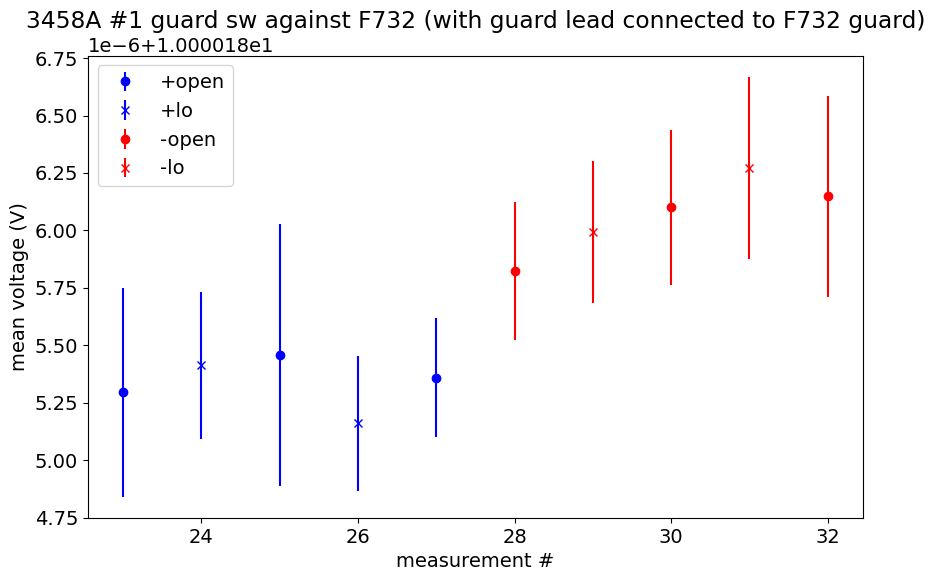

In [ ]:
ag3458a1_guard_f732 = ag3458a1_guard_grouped[ag3458a1_guard_grouped['dut']['last'] == 'F732a1']
ag3458a1_guard_f732_to_guard = ag3458a1_guard_f732[ag3458a1_guard_f732['guard_setting']['last'].str.startswith('Lead to guard')].copy()
ag3458a1_guard_f732_to_guard.loc[ag3458a1_guard_f732_to_guard['guard_setting']['last'].str.endswith(', open'), 'guard_switch'] = 'open'
ag3458a1_guard_f732_to_guard.loc[ag3458a1_guard_f732_to_guard['guard_setting']['last'].str.endswith(', lo'), 'guard_switch'] = 'lo'

ag3458a1_guard_grouped_pos_open = ag3458a1_guard_f732_to_guard[(ag3458a1_guard_f732_to_guard['dut_setting']['last'] == '10 V') & (ag3458a1_guard_f732_to_guard['guard_switch'] == 'open')]
ag3458a1_guard_grouped_pos_lo = ag3458a1_guard_f732_to_guard[(ag3458a1_guard_f732_to_guard['dut_setting']['last'] == '10 V') & (ag3458a1_guard_f732_to_guard['guard_switch'] == 'lo')]
ag3458a1_guard_grouped_neg_open = ag3458a1_guard_f732_to_guard[(ag3458a1_guard_f732_to_guard['dut_setting']['last'] == '-10 V') & (ag3458a1_guard_f732_to_guard['guard_switch'] == 'open')]
ag3458a1_guard_grouped_neg_lo = ag3458a1_guard_f732_to_guard[(ag3458a1_guard_f732_to_guard['dut_setting']['last'] == '-10 V') & (ag3458a1_guard_f732_to_guard['guard_switch'] == 'lo')]

plt.errorbar(ag3458a1_guard_grouped_pos_open.index, np.abs(ag3458a1_guard_grouped_pos_open['ag3458a_1_dcv']['mean']), yerr=ag3458a1_guard_grouped_pos_open['ag3458a_1_dcv']['std'], fmt='o', c='blue', label='+open')
plt.errorbar(ag3458a1_guard_grouped_pos_lo.index, np.abs(ag3458a1_guard_grouped_pos_lo['ag3458a_1_dcv']['mean']), yerr=ag3458a1_guard_grouped_pos_lo['ag3458a_1_dcv']['std'], fmt='x', c='blue', label='+lo')
plt.errorbar(ag3458a1_guard_grouped_neg_open.index, np.abs(ag3458a1_guard_grouped_neg_open['ag3458a_1_dcv']['mean']), yerr=ag3458a1_guard_grouped_neg_open['ag3458a_1_dcv']['std'], fmt='o', c='red', label='-open')
plt.errorbar(ag3458a1_guard_grouped_neg_lo.index, np.abs(ag3458a1_guard_grouped_neg_lo['ag3458a_1_dcv']['mean']), yerr=ag3458a1_guard_grouped_neg_lo['ag3458a_1_dcv']['std'], fmt='x', c='red', label='-lo')
plt.legend()
plt.xlabel('measurement #')
plt.ylabel('mean voltage (V)')
plt.title('3458A #1 guard sw against F732 (with guard lead connected to F732 guard)', pad=20)

Text(0.5, 1.0, '3458A #1 guard sw against F732 (with guard lead connected to lo at F732)')

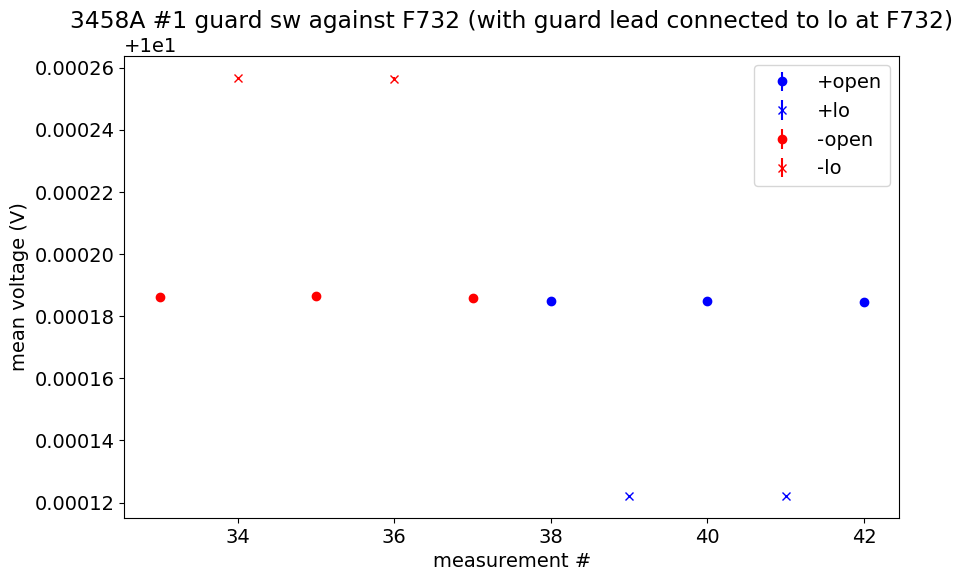

In [ ]:
ag3458a1_guard_f732 = ag3458a1_guard_grouped[ag3458a1_guard_grouped['dut']['last'] == 'F732a1']
ag3458a1_guard_f732_to_guard = ag3458a1_guard_f732[ag3458a1_guard_f732['guard_setting']['last'].str.startswith('Lead to lo')].copy()
ag3458a1_guard_f732_to_guard.loc[ag3458a1_guard_f732_to_guard['guard_setting']['last'].str.endswith(', open'), 'guard_switch'] = 'open'
ag3458a1_guard_f732_to_guard.loc[ag3458a1_guard_f732_to_guard['guard_setting']['last'].str.endswith(', lo'), 'guard_switch'] = 'lo'

ag3458a1_guard_grouped_pos_open = ag3458a1_guard_f732_to_guard[(ag3458a1_guard_f732_to_guard['dut_setting']['last'] == '10 V') & (ag3458a1_guard_f732_to_guard['guard_switch'] == 'open')]
ag3458a1_guard_grouped_pos_lo = ag3458a1_guard_f732_to_guard[(ag3458a1_guard_f732_to_guard['dut_setting']['last'] == '10 V') & (ag3458a1_guard_f732_to_guard['guard_switch'] == 'lo')]
ag3458a1_guard_grouped_neg_open = ag3458a1_guard_f732_to_guard[(ag3458a1_guard_f732_to_guard['dut_setting']['last'] == '-10 V') & (ag3458a1_guard_f732_to_guard['guard_switch'] == 'open')]
ag3458a1_guard_grouped_neg_lo = ag3458a1_guard_f732_to_guard[(ag3458a1_guard_f732_to_guard['dut_setting']['last'] == '-10 V') & (ag3458a1_guard_f732_to_guard['guard_switch'] == 'lo')]

plt.errorbar(ag3458a1_guard_grouped_pos_open.index, np.abs(ag3458a1_guard_grouped_pos_open['ag3458a_1_dcv']['mean']), yerr=ag3458a1_guard_grouped_pos_open['ag3458a_1_dcv']['std'], fmt='o', c='blue', label='+open')
plt.errorbar(ag3458a1_guard_grouped_pos_lo.index, np.abs(ag3458a1_guard_grouped_pos_lo['ag3458a_1_dcv']['mean']), yerr=ag3458a1_guard_grouped_pos_lo['ag3458a_1_dcv']['std'], fmt='x', c='blue', label='+lo')
plt.errorbar(ag3458a1_guard_grouped_neg_open.index, np.abs(ag3458a1_guard_grouped_neg_open['ag3458a_1_dcv']['mean']), yerr=ag3458a1_guard_grouped_neg_open['ag3458a_1_dcv']['std'], fmt='o', c='red', label='-open')
plt.errorbar(ag3458a1_guard_grouped_neg_lo.index, np.abs(ag3458a1_guard_grouped_neg_lo['ag3458a_1_dcv']['mean']), yerr=ag3458a1_guard_grouped_neg_lo['ag3458a_1_dcv']['std'], fmt='x', c='red', label='-lo')
plt.legend()
plt.xlabel('measurement #')
plt.ylabel('mean voltage (V)')
plt.title('3458A #1 guard sw against F732 (with guard lead connected to lo at F732)', pad=20)

In [ ]:
ag3458a1_guard_f732

dut dut_setting        guard_setting ag3458a_1_dcv                \
         last        last                 last          mean           std   
group                                                                        
23     F732a1        10 V  Lead to guard, open     10.000185  4.539821e-07   
24     F732a1        10 V    Lead to guard, lo     10.000185  3.206153e-07   
25     F732a1        10 V  Lead to guard, open     10.000185  5.713446e-07   
26     F732a1        10 V    Lead to guard, lo     10.000185  2.936912e-07   
27     F732a1        10 V  Lead to guard, open     10.000185  2.594115e-07   
28     F732a1       -10 V  Lead to guard, open    -10.000186  3.000883e-07   
29     F732a1       -10 V    Lead to guard, lo    -10.000186  3.108898e-07   
30     F732a1       -10 V  Lead to guard, open    -10.000186  3.370272e-07   
31     F732a1       -10 V    Lead to guard, lo    -10.000186  3.970763e-07   
32     F732a1       -10 V  Lead to guard, open    -10.000186  4.378443e-07   
33     F732a1       -10 V     Lead to lo, open    -10.000186  2.409596e-07   
34     F732a1       -10 V       Lead to lo, lo    -10.000257  3.256494e-07   
35     F732a1       -10 V     Lead to lo, open    -10.000186  2.992651e-07   
36     F732a1       -10 V       Lead to lo, lo    -10.000256  4.321510e-07   
37     F732a1       -10 V     Lead to lo, open    -10.000186  4.104953e-07   
38     F732a1        10 V     Lead to lo, open     10.000185  3.856991e-07   
39     F732a1        10 V       Lead to lo, lo     10.000122  2.226017e-07   
40     F732a1        10 V     Lead to lo, open     10.000185  4.177857e-07   
41     F732a1        10 V       Lead to lo, lo     10.000122  2.683601e-07   
42     F732a1        10 V     Lead to lo, open     10.000185  3.119108e-07   

             
      count  
group        
23       20  
24       22  
25      118  
26       23  
27       25  
28       23  
29       26  
30       25  
31       23  
32       29  
33       27  
34       26  
35       29  
36       28  
37       35  
38      164  
39       26  
40      191  
41       30  
42       54

## Effect of mains vs battery power on Fluke 7001
Using Mascot type 9783 linear power supply. Constantly measuring back to back with Fluke 732a3 using Keithley 182 nanovoltmeter.

In [ ]:
_, files = read_data(["k182-dcv-mv-log-unattended-F7001-bat-and-net-power.csv"])
f7001_mains_bat_data = files["k182-dcv-mv-log-unattended-F7001-bat-and-net-power.csv"]

In [ ]:
f7001_mains_bat_data_grouped = add_dut_neg_and_pos_group(f7001_mains_bat_data)

In [ ]:
duration_data = f7001_mains_bat_data_grouped.reset_index().groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max', 'mean'], 'k182_dcv': ['mean', 'sem', 'count']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data[[('datetime', 'min'), ('datetime', 'max'), ('duration',''), ('k182_dcv', 'mean'), ('k182_dcv', 'sem'), ('k182_dcv', 'count')]].sort_values(('datetime', 'min')))

datetime  \
                                                       min   
group dut_neg_lead dut_pos_lead                              
1     F732a3       short        2023-10-01 20:35:14.534478   
2     F732a3       F7001        2023-10-01 20:51:16.906239   
3     F732a3       F7001bat     2023-10-01 21:36:35.940055   
4     F732a3       F7001        2023-10-01 23:17:54.264269   
5     F732a3       short        2023-10-01 23:56:23.592249   
6     F732a3       F7001        2023-10-02 00:03:50.897193   
7     F732a3       F7001bat     2023-10-03 21:40:26.789355   
8     F732a3       F7001        2023-10-03 23:46:10.869581   
9     F732a3       short        2023-10-04 06:43:43.640607   
10    F732a3       F7001        2023-10-04 07:21:55.514959   
11    F732a3       short        2023-10-05 13:32:00.455240   
12    F732a3       F7001        2023-10-05 13:57:06.095337   
13    F732a3       short        2023-10-05 19:38:23.351095   
14    F732a3       F7001        2023-10-05 20:09:36.092030   
15    F732a3       F7001bat     2023-10-05 21:17:30.730195   
16    F732a3       F7001        2023-10-05 23:31:46.753215   
17    F732a3       short        2023-10-06 15:21:36.658239   
18    F7001        F732a3       2023-10-06 15:42:58.883002   
19    F732a3       F7001        2023-10-06 15:54:47.921144   
20    F732a3       short        2023-10-07 17:54:13.773802   
21    F7001        F732a3       2023-10-07 18:09:03.717167   
22    F732a3       F7001        2023-10-07 18:27:38.246769   
23    F732a3       F7001bat     2023-10-07 20:24:08.896578   
24    F732a3       F7001        2023-10-07 23:18:53.740764   

                                                            \
                                                       max   
group dut_neg_lead dut_pos_lead                              
1     F732a3       short        2023-10-01 20:43:31.497797   
2     F732a3       F7001        2023-10-01 21:35:38.600531   
3     F732a3       F7001bat     2023-10-01 23:16:30.414708   
4     F732a3       F7001        2023-10-01 23:53:06.680813   
5     F732a3       short        2023-10-02 00:00:56.268342   
6     F732a3       F7001        2023-10-03 21:36:43.740787   
7     F732a3       F7001bat     2023-10-03 23:42:59.086544   
8     F732a3       F7001        2023-10-04 06:38:59.918482   
9     F732a3       short        2023-10-04 07:19:20.138659   
10    F732a3       F7001        2023-10-05 13:28:19.160158   
11    F732a3       short        2023-10-05 13:52:17.138241   
12    F732a3       F7001        2023-10-05 19:32:13.862812   
13    F732a3       short        2023-10-05 20:04:40.358936   
14    F732a3       F7001        2023-10-05 21:13:37.238056   
15    F732a3       F7001bat     2023-10-05 23:29:07.620488   
16    F732a3       F7001        2023-10-06 15:15:39.380922   
17    F732a3       short        2023-10-06 15:37:55.040174   
18    F7001        F732a3       2023-10-06 15:51:06.136028   
19    F732a3       F7001        2023-10-07 17:48:04.463100   
20    F732a3       short        2023-10-07 18:05:28.916461   
21    F7001        F732a3       2023-10-07 18:23:10.151345   
22    F732a3       F7001        2023-10-07 20:19:53.715316   
23    F732a3       F7001bat     2023-10-07 23:15:16.804215   
24    F732a3       F7001        2023-10-08 11:20:56.879788   

                                              duration      k182_dcv  \
                                                                mean   
group dut_neg_lead dut_pos_lead                                        
1     F732a3       short        0 days 00:08:16.963319  2.830795e-07   
2     F732a3       F7001        0 days 00:44:21.694292  1.750201e-04   
3     F732a3       F7001bat     0 days 01:39:54.474653  1.755278e-04   
4     F732a3       F7001        0 days 00:35:12.416544  1.754136e-04   
5     F732a3       short        0 days 00:04:32.676093  2.095921e-07   
6     F732a3       F7001        1 days 21:32:52.843594  1.747734e-04   
7     F732a3       F7001bat     0 days 02:02:32.2971

In [ ]:
f7001_mains_bat_exp1 = f7001_mains_bat_data_grouped[f7001_mains_bat_data_grouped.group.isin((2,3,4,6)) & (f7001_mains_bat_data_grouped.index < pd.Timestamp(2023,10,2,1,17))]
f7001_mains_bat_exp2 = f7001_mains_bat_data_grouped[f7001_mains_bat_data_grouped.group.isin((6,7,8)) & (f7001_mains_bat_data_grouped.index > pd.Timestamp(2023,10,3,19,40)) & (f7001_mains_bat_data_grouped.index < pd.Timestamp(2023,10,4,1,43))]
f7001_mains_bat_exp3 = f7001_mains_bat_data_grouped[f7001_mains_bat_data_grouped.group.isin((14,15,16)) & (f7001_mains_bat_data_grouped.index < pd.Timestamp(2023,10,6,1,30))]
f7001_mains_bat_exp4 = f7001_mains_bat_data_grouped[f7001_mains_bat_data_grouped.group.isin((22,23,24)) & (f7001_mains_bat_data_grouped.index < pd.Timestamp(2023,10,8,1,15))]

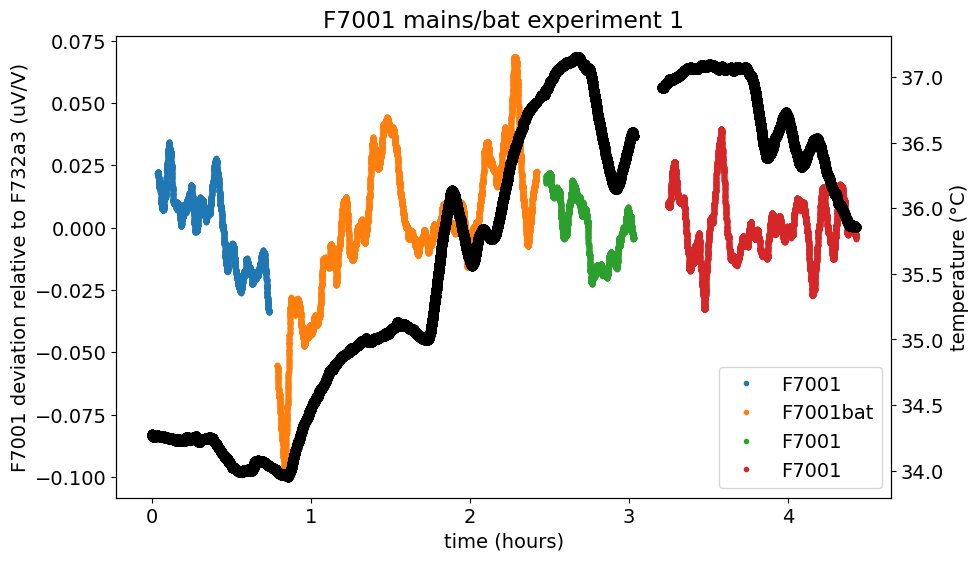

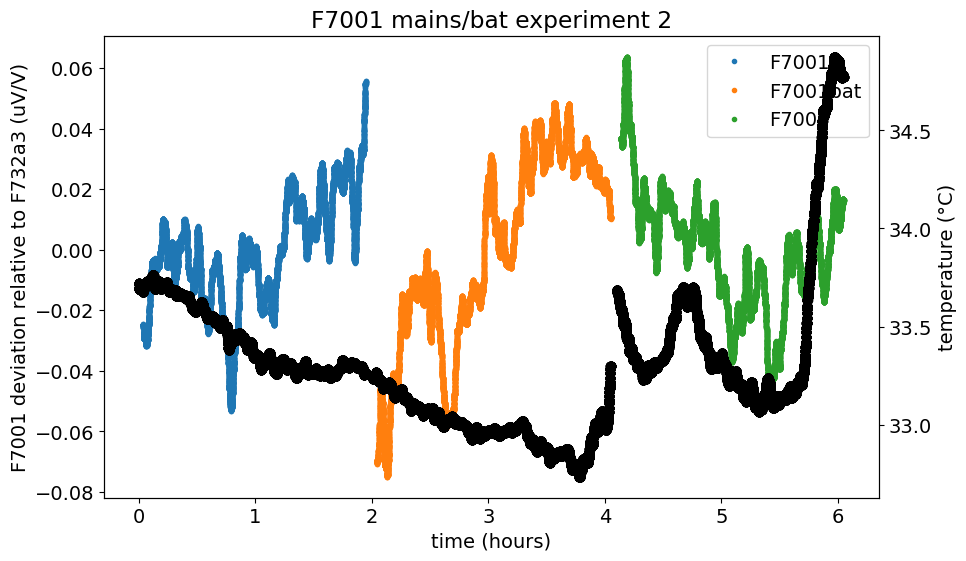

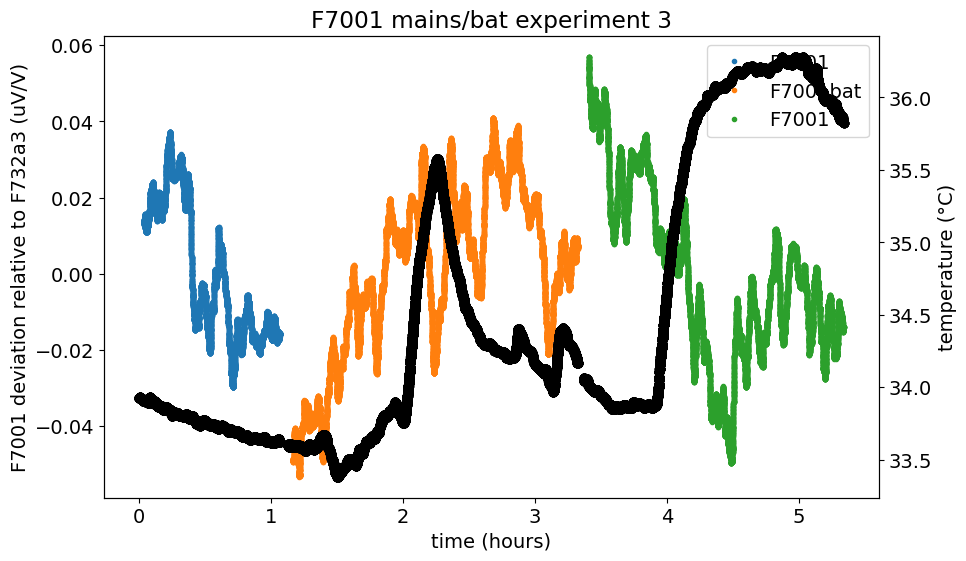

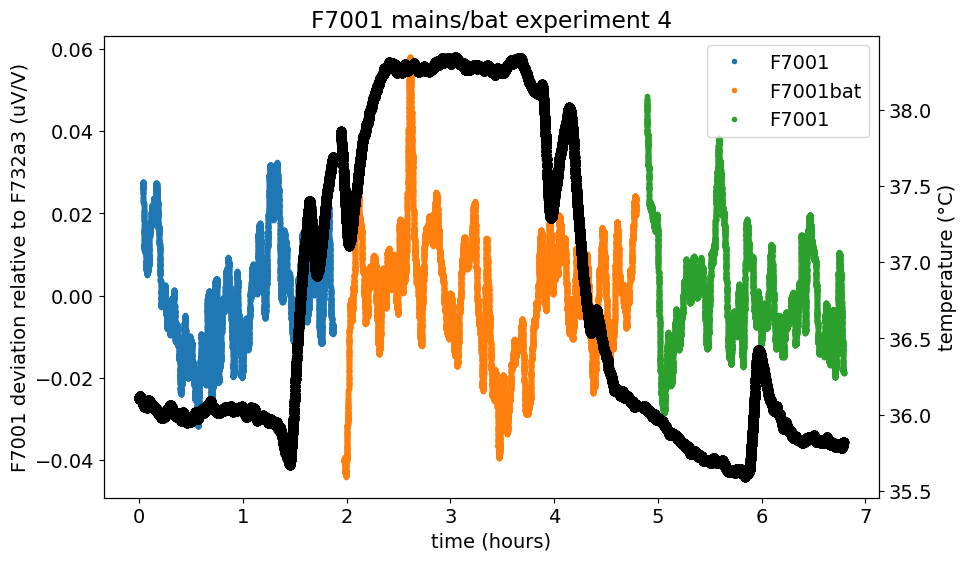

In [ ]:
def plot_f7001_mains_bat_exp(exp_number, data):
    data = data.copy()
    ax = plt.gca()
    ax.set_title(f'F7001 mains/bat experiment {exp_number}')
    ax.set_ylabel('F7001 deviation relative to F732a3 (uV/V)')
    ax.set_xlabel('time (hours)')
    data.relative_time = (data.index - data.index[0]).total_seconds() / 3600
    for group in data.group.unique():
        group_data = data[data.group == group]
        approx_absolute_value = 10 + group_data.k182_dcv
        ppm_deviation = (approx_absolute_value - approx_absolute_value.mean()) / approx_absolute_value.mean() * 1e6
        ax.plot(group_data.relative_time, ppm_deviation.rolling(500).mean(), '.', label=group_data.dut_pos_lead.iloc[0])
    y2 = ax.twinx()
    y2.set_ylabel('temperature (°C)')
    y2.plot(data.relative_time, data.temperature, 'o', label='temperature', color='black')
    ax.legend()
    plt.show()
plot_f7001_mains_bat_exp(1, f7001_mains_bat_exp1)
plot_f7001_mains_bat_exp(2, f7001_mains_bat_exp2)
plot_f7001_mains_bat_exp(3, f7001_mains_bat_exp3)
plot_f7001_mains_bat_exp(4, f7001_mains_bat_exp4)

In [5]:
np.random.seed(0)
unif = [np.random.uniform(-1, 1, 1000) for i in range(100)]
norm = [np.random.normal(0, 0.5, 1000) for i in range(100)]
pois = [np.random.poisson(0.5, 1000) for i in range(100)]

In [12]:
from math import sqrt

def avg_over_block(sequence, block_size):
    return [np.mean(sequence[i:i+block_size]) for i in range(0, len(sequence), block_size)]

unif_avg = [avg_over_block(sequence, 10) for sequence in unif]
unif_stderr_raw = [np.std(sequence) / sqrt(len(sequence)) for sequence in unif]
unif_stderr_avg = [np.std(sequence) / sqrt(len(sequence)) for sequence in unif_avg]

norm_avg = [avg_over_block(sequence, 10) for sequence in norm]
norm_stderr_raw = [np.std(sequence) / sqrt(len(sequence)) for sequence in norm]
norm_stderr_avg = [np.std(sequence) / sqrt(len(sequence)) for sequence in norm_avg]

In [10]:
np.array(unif_stderr_raw) - np.array(unif_stderr_avg)

array([-1.58272345e-03, -1.82937395e-03,  3.56534905e-04, -4.09076114e-04,
       -3.46430820e-04,  9.41140804e-04,  4.56290077e-04,  9.70348314e-04,
        4.85381032e-04, -1.71865589e-03,  2.39195745e-03, -8.25196472e-04,
       -1.17973153e-03,  2.29041877e-04, -2.05862452e-03, -5.31972659e-05,
        2.40311752e-04,  5.13202570e-04,  2.27790639e-03,  9.05344277e-04,
       -5.84983524e-04, -5.35732537e-04, -9.66201811e-05,  5.95820381e-04,
       -9.56702836e-04,  5.99978178e-04,  2.39289646e-03,  5.92060954e-04,
        1.84230251e-04,  1.60391487e-03, -5.19284599e-04,  7.38057339e-04,
       -5.47086277e-04, -2.49745289e-03,  5.82997836e-05, -2.16098890e-04,
        5.90684510e-05,  3.11660019e-04, -1.09945163e-03, -1.16284475e-03,
       -5.58551516e-04, -6.38912211e-04, -1.38282524e-03, -8.33513684e-04,
       -2.19514465e-03,  9.58473223e-04, -1.58399135e-03,  2.19110323e-03,
       -1.18816145e-03,  8.37260826e-04,  2.03037732e-03,  5.77299193e-04,
        2.21892315e-03,  

In [13]:
np.array(norm_stderr_raw) - np.array(norm_stderr_avg)

array([ 2.68124463e-04,  4.91416658e-04,  5.66761626e-04, -1.79740411e-03,
       -1.37970176e-03, -7.41433146e-04, -3.14231254e-04,  1.79798848e-04,
        1.26204744e-03, -6.55972893e-04,  1.39823562e-03,  1.35506155e-03,
        1.62014253e-03, -6.68759575e-04,  1.51855036e-03,  1.77718441e-04,
       -1.00556405e-03, -1.37192615e-04, -1.69204025e-03, -4.95036098e-04,
       -7.57638296e-05,  1.08072395e-04, -5.09738850e-04,  2.65671938e-03,
        7.93203421e-04,  7.58336602e-04, -4.85129573e-04, -8.46392416e-04,
       -2.44194711e-04, -1.22768543e-03, -6.20963104e-04,  3.01069711e-04,
       -1.54564888e-04,  3.06421542e-03, -8.56783995e-04, -4.67134072e-04,
        4.30789258e-04,  9.60699172e-05, -3.45407528e-04, -5.25765910e-04,
        9.81802735e-04, -6.63143657e-04, -2.57332403e-04,  2.81746837e-04,
        2.59143299e-04, -1.44082036e-03,  2.45268903e-03,  6.69756715e-06,
       -6.48471583e-04, -1.05194290e-03, -1.49650919e-04,  1.67380869e-03,
        4.83067496e-04,  